# Human Tumors



In [1]:
# import mazebox as mb
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
import dropkick as dk
# make sure to use position 1
sys.path.insert(1, "/Users/smgroves/Documents/GitHub/Groves-CellSys2021/")
import mazebox as mb
import cellrank as cr
import scanorama

In [2]:
adata = cr.read('../../out/human-tumors/adata_02.h5ad')


/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


In [3]:
X_magic = cr.read('../../out/human-tumors/X_magic_02.h5ad')
X_magic

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


AnnData object with n_obs × n_vars = 1596 × 13593
    obs: 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'tumor', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'PTPRC+', 'COL1A1+', 'pca_cutoff', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'specialists_pca_diffdist'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-Tumor 1', 'dropkick_coef-Tumor 2', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'n_cells'
    uns: 'pca', 'specialists_pca_diffdist_colors', 'tumor_colors'
    obsm: 'X_pca', 'arc_distance'
    varm: 'PCs'

In [4]:
adata.layers['imputed'] = X_magic.X
adata.obsm['X_pca_imputed'] = X_magic.obsm['X_pca']

In [5]:
adata.write_h5ad('../../out/human-tumors/adata_03.h5ad')

# Subtyping with Archetype Signatures

In [6]:
adata = cr.read('../../out/human-tumors/adata_03.h5ad')

/Users/smgroves/Documents/anaconda3/envs/mazebox_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `cellrank.tl.read` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  """Entry point for launching an IPython kernel.


## Using Mazebox to generate archetype scores

In [7]:
sig_matrix = pd.read_csv('../../out/bulk/sig_matrix_ParTI_2021.csv', header =0, index_col = 0)

sig_matrix = sig_matrix / np.linalg.norm(sig_matrix, axis=0)


In [8]:
# import seaborn as sns
# max_subtype = []
# max_v = []
# sig_matrix_copy = sig_matrix.copy()
# for i,r in sig_matrix.iterrows():
#     maxi = r.idxmax()
#     maxv = r.max()
#     max_subtype.append(maxi) 
#     max_v.append(maxv)
# sig_matrix_copy['max_subtype'] = max_subtype
# sig_matrix_copy['max'] = max_v

# plt.figure(figsize=(5,30))
# sig_matrix_copy = sig_matrix_copy.sort_values(by = ['max_subtype','max'], ascending=[True, False])
# sig_matrix_copy = sig_matrix_copy[['SCLC-A','SCLC-A2','SCLC-N','SCLC-P','SCLC-Y']]
# sns.heatmap(sig_matrix_copy, cmap='viridis', yticklabels = True)
# plt.xticks(rotation = 90)
# plt.title(f'Log-transformed Archetype Expression Profiles')
# plt.tight_layout()
# # plt.savefig(op.join(outdir,f'figures/Archetypes/sig_matrix_logfc.pdf'))
# plt.show()
# plt.close()

# sig_matrix_copy.to_csv('../data/sig_matrix_ParTI.csv')

If the below code gives an error about data shape, use `type = 'csr'`.

Cells with zero expression for all genes in gene signature will get scores of NaN when assigning scores in adata.obs (because these cells are filtered for the calculation). 

Trying to set attribute `.obs` of view, copying.


Transforming tumor data...
Gene signature matrix now has shape:  (76, 5)
Tumor data shortened to genes in gene list...
(1551, 76)
Tumor data subsetting complete.


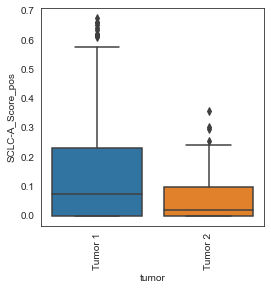

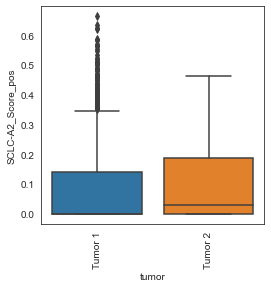

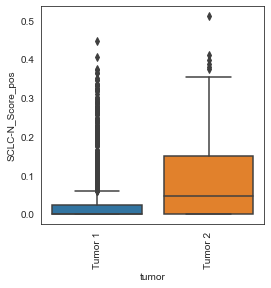

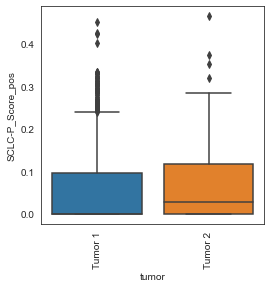

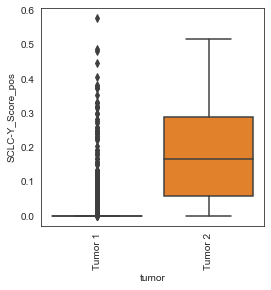

In [9]:
adata, adata_small, sig_matrix2 = mb.ar.phenotyping_recipe(adata, sig_matrix, groupby = 'tumor',velocity=False)


In [10]:
from sklearn.manifold import LocallyLinearEmbedding
def _archetype_diagram_no_arrows(_adata, score_name, color, figsize, order, multiplier,fname,
                                 sizes = None, alpha = .3, s = 30, color_dict = None, norm = 'scale'):
    # X = subtype scores for each subtype (pd dataframe)
    n_samples = len(_adata.obs_names)

    n_types = len(sig_matrix.columns)
    subtypes = sig_matrix.columns
    X = _adata.obs[[f"{x}{score_name}" for x in subtypes]]
    top = X.sum().sort_values(ascending=False)[:3]  # return a list of n largest element
    print(top.index)

    # normalize X to sum to 1 (makes sure that the data fits within the archetype diagram with I matrix = vertices
    X_norm = pd.DataFrame(columns=X.columns)
    if norm == 'scale':
        for i, r in X.iterrows():
            if r.sum() == 0:
                X_norm = X_norm.append(r)
            else:
                X_norm = X_norm.append(r / r.sum())
    elif norm == 'max':
        max = X.max().max()
        X_norm = X / max
    elif norm == 'None':
        X_norm = X

    X = X_norm.fillna(0)
    if type(order) != type(None):
        X = X[[f"{x}{score_name}" for x in order]]
        subtypes = order
    else:
        order = subtypes

    ident = np.identity(n_types)
    for i, x in enumerate(subtypes):
        X = X.append(pd.DataFrame(np.array(ident[i]), index=X.columns, columns=[x]).T)

    embedding = LocallyLinearEmbedding(n_components=2, n_neighbors=4, method='modified', eigen_solver='dense')
    X_transformed = embedding.fit_transform(X[-n_types:])
    X_transformed = X_transformed.T

    X_df_data = embedding.transform(X[:-n_types])
    X_df_data = X_df_data.T

    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot()
    colors = _adata.obs[color].values
    if type(colors[0]) == str:
        c = [color_dict[i] for i in colors]
    else:
        c = colors
    plt.scatter(X_df_data[0], X_df_data[1], c=c, zorder=1, alpha=alpha, s=s)
    if type(sizes) == int:
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    else:
        sizes = [Counter(colors)[i] * multiplier / n_samples for i in order]
        print(sizes)
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                zorder=2, s=sizes)
    plt.axis('tight')
    plt.savefig(f'./figures/{fname}.pdf')
    plt.show()
    plt.close()
    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot()
    colors = _adata.obs[color].values
    if type(colors[0]) == str:
        c = [color_dict[i] for i in colors]
    else:
        c = colors
    sns.kdeplot(X_df_data[0], X_df_data[1], cmap="Reds", shade=True, bw=.15)
    if type(sizes) == int:
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    else:
        sizes = [Counter(colors)[i] * multiplier / n_samples for i in order]
        print(sizes)
        plt.scatter(X_transformed[0, -n_types:], X_transformed[1, -n_types:], c='black',
                    zorder=2, s=sizes)
    plt.axis('tight')
    plt.show()
    plt.close()


Index(['SCLC-A_Score', 'SCLC-A2_Score', 'SCLC-P_Score'], dtype='object')


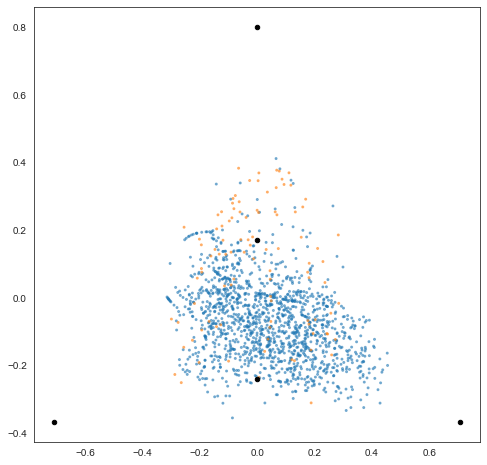

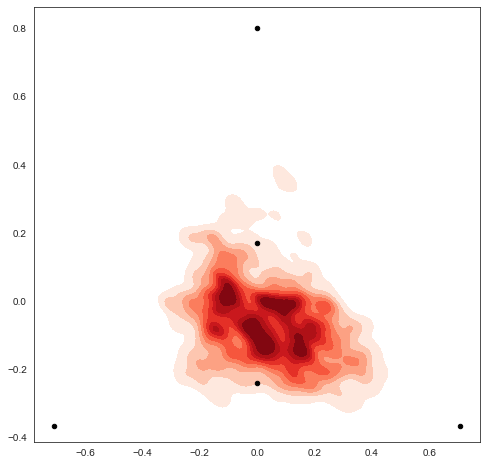

In [11]:
color_dict = {}
for i,c in enumerate(sorted(list(set(adata_small.obs['tumor'])))):
    if i == 7:     color_dict[c] = sns.color_palette('tab10')[9] #skip grey
    else:
        color_dict[c] = sns.color_palette('tab10',8)[i]
cmap = 'jet'
_archetype_diagram_no_arrows(adata_small, color_dict=color_dict,color='tumor',fname = 'tumor_archetype_space',
                        order = ['SCLC-Y','SCLC-A','SCLC-P','SCLC-N','SCLC-A2'], norm = 'None',
                        multiplier=1, figsize=(8,8), score_name = '_Score', alpha = .5, s = 4, sizes = 20)


## Newer phenotype classification with labeled generalists
Let's check to see how many samples have significant scores (p>.3) for more than one phenotype.

<BarContainer object of 3 artists>

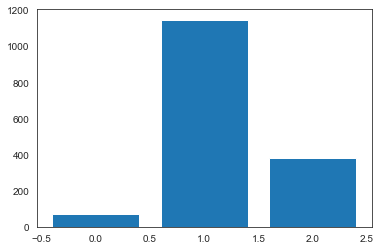

In [12]:
df = adata.obs[[f"{x}_Score_pos" for x in ['SCLC-N', 'SCLC-A', 'SCLC-P', 'SCLC-Y', 'SCLC-A2']]]
# np.unique((df > .3).sum(axis = 1), return_counts=True)[1]
plt.bar(height = np.unique(((df.T/df.sum(axis = 1)).T > .33).sum(axis = 1), return_counts=True)[1], x = range(3), log=False)

In [13]:
arc_pheno = []
arc_aa_type = []

for i,r in df.iterrows():
    r = r/r.sum()
    if (r > .33).sum() > 1:
        arc_aa_type.append('Generalist')
        arc_pheno.append(r.sort_values(ascending=False)[0:2].sort_index().index[0].split('_')[0]+"_"+r.sort_values(ascending=False)[0:2].sort_index().index[1].split('_')[0])
    elif  (r > .33).sum() == 1:
        try:
            arc_aa_type.append(r.idxmax().split('_')[0]+" Specialist")
            arc_pheno.append(r.idxmax().split('_')[0])
        except AttributeError: 
            arc_aa_type.append("Unclassified")
            arc_pheno.append("Unclassified")
    else: 
        arc_aa_type.append("Unclassified")
        arc_pheno.append("Unclassified")
adata.obs['arc_pheno'] = arc_pheno
adata.obs['arc_aa_type'] = arc_aa_type


In [14]:
pd.crosstab(adata.obs['arc_pheno'],adata.obs['tumor']).style.background_gradient(cmap='viridis')

In [15]:
pd.crosstab( adata.obs['arc_pheno'],adata.obs['Phenotype']).style.background_gradient(cmap='viridis')

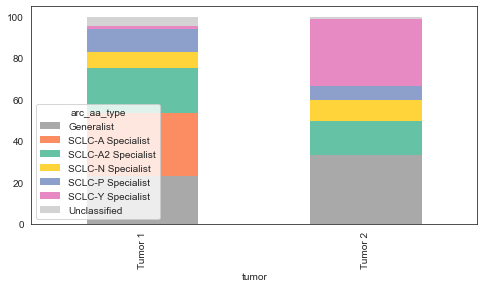

In [16]:
cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
color_dict = {'SCLC-Y Specialist': cp[4], 'SCLC-A Specialist': cp[0], 'SCLC-A2 Specialist': cp[1], 'SCLC-N Specialist': cp[2], 'SCLC-P Specialist': cp[3],
              'Generalist': 'darkgrey', 'Unclassified': 'lightgrey'}
mb.pl.subtype_bar(adata,groupby='tumor', fname = 'tumor', pheno_name="arc_aa_type", custom_palette=color_dict)

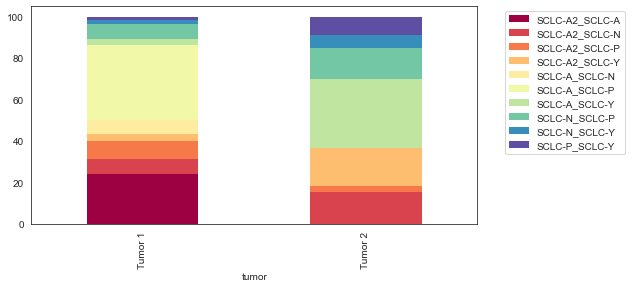

In [17]:
_adata = adata[adata.obs['arc_aa_type'] == 'Generalist']
plt.rcParams["figure.figsize"] = [8, 4]
((pd.crosstab(_adata.obs["tumor"], _adata.obs['arc_pheno']).T /
  pd.crosstab(_adata.obs["tumor"], _adata.obs['arc_pheno']).sum(axis=1)) * 100).T.plot(kind='bar',
                                                                                              stacked=True,
                                                                                              linewidth=0, cmap = 'Spectral')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.savefig('./figures/arc_aa_generalist_subtypes.pdf')

In [18]:
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 300
# mb.pl.archetype_diagrams(adata, sig_matrix, color_dict=color_dict, groupby='cline',color = 'arc_aa_type',
#                         order = ['SCLC-Y','SCLC-A','SCLC-P','SCLC-N','SCLC-A2'], norm = 'None',sizes = 20,
#                         figsize=(4,4), score_name = '_Score', alpha = .8, s = 8, arrows = False)


In [19]:
np.unique(adata.obs['arc_pheno'], return_counts=True)

(array(['SCLC-A', 'SCLC-A2', 'SCLC-A2_SCLC-A', 'SCLC-A2_SCLC-N',
        'SCLC-A2_SCLC-P', 'SCLC-A2_SCLC-Y', 'SCLC-A_SCLC-N',
        'SCLC-A_SCLC-P', 'SCLC-A_SCLC-Y', 'SCLC-N', 'SCLC-N_SCLC-P',
        'SCLC-N_SCLC-Y', 'SCLC-P', 'SCLC-P_SCLC-Y', 'SCLC-Y',
        'Unclassified'], dtype=object),
 array([450, 342,  84,  29,  32,  18,  22, 126,  22, 125,  30,   9, 174,
          8,  54,  71]))

In [20]:
adata.write_h5ad('../../out/human-tumors/adata_03.h5ad')



... storing 'Phenotype' as categorical
... storing 'arc_pheno' as categorical
... storing 'arc_aa_type' as categorical


Keep in mind that the ternary plots are renormalized, so the cell labeled A2, for example, shows up in the middle of the plot because A, N, and Y are renormalized to sum to 1 even though A2 was the highest probability phenotype.

# PCHA subtyping

In [2]:
adata = sc.read_h5ad('../../out/human-tumors/adata_03.h5ad')


In [3]:
X_magic = sc.read_h5ad('../../out/human-tumors/X_magic_02.h5ad')

In [6]:
S_matrix = pd.read_csv('../../out/human-tumors/ParetoTI/S.csv', index_col=0)

In [7]:
S_matrix

V1        V2  \
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.933531  0.066469   
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.987398  0.012602   
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.931295  0.062136   
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.842221  0.112513   
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.427982  0.443487   
...                                                      ...       ...   
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TGAGCGCATTCCCCT...  0.514510  0.037389   
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TGAGGGAAATCACCA...  0.001840  0.000000   
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TTATAGCCGACAACT...  0.210193  0.338606   
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TTTGTGTCCCTACTA...  0.100192  0.000000   
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TGGTATGACCCTAAC...  0.184199  0.055505   

                                                          V3  
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.000000  
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.000000  
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.006570  
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.045266  
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.128531  
...                                                      ...  
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TGAGCGCATTCCCCT...  0.448101  
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TGAGGGAAATCACCA...  0.998160  
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TTATAGCCGACAACT...  0.451201  
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TTTGTGTCCCTACTA...  0.899808  
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TGGTATGACCCTAAC...  0.760295  

[1596 rows x 3 columns]

[<AxesSubplot:xlabel='PC1', ylabel='PC2'>,
 <AxesSubplot:xlabel='PC1', ylabel='PC2'>,
 <AxesSubplot:xlabel='PC1', ylabel='PC2'>]

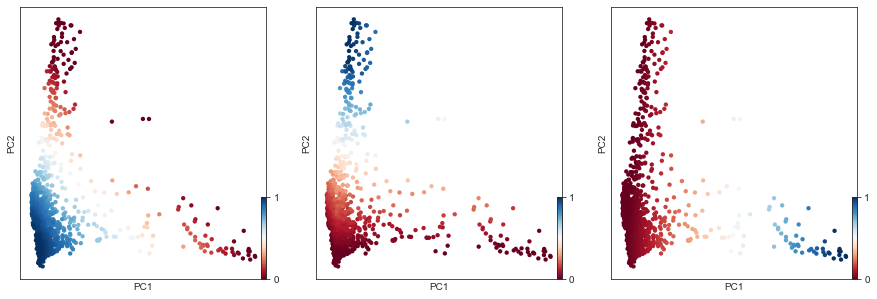

In [11]:
scv.pl.pca(X_magic, c = [S_matrix[i] for i in ['V1','V2','V3']], components='1,2', show=False, figsize= (5,5),ncols = 3, frameon=True, cmap = 'RdBu')


In [12]:
X_magic.obsm['ParetoTI_S'] = S_matrix

In [13]:
tmp = X_magic.obsm['ParetoTI_S'].copy()

for arc in  X_magic.obsm['ParetoTI_S'].columns:
    closest = X_magic.obsm['ParetoTI_S'].loc[X_magic.obsm['ParetoTI_S'][arc].sort_values(ascending = False) > .8]
    tmp.loc[closest.index,'specialist'] = arc
X_magic.obs['specialists_ParetoTI_S'] = tmp.specialist
X_magic.obs['specialists_ParetoTI_S'].value_counts()

V1    1229
V2      71
V3      30
Name: specialists_ParetoTI_S, dtype: int64

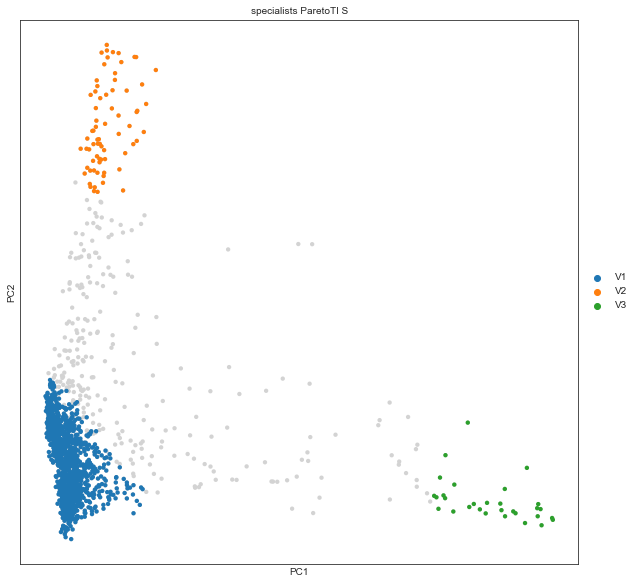

In [14]:
scv.pl.pca(X_magic, color = 'specialists_ParetoTI_S', figsize= (10,10), frameon=True, legend_loc = 'on right')


In [15]:
X_magic.obs = pd.merge(adata.obs.arc_aa_type,X_magic.obs, left_index=True, right_index=True)

In [16]:
X_magic.obs = pd.merge(adata.obs[[i for i in adata.obs if '_Score_pos' in i]],X_magic.obs, left_index=True, right_index=True)

In [25]:
X_magic.obs = X_magic.obs.fillna({i:0 for i in adata.obs if '_Score_pos' in i})

In [35]:
scv.pp.neighbors(X_magic)

computing neighbors
    finished (0:00:10) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


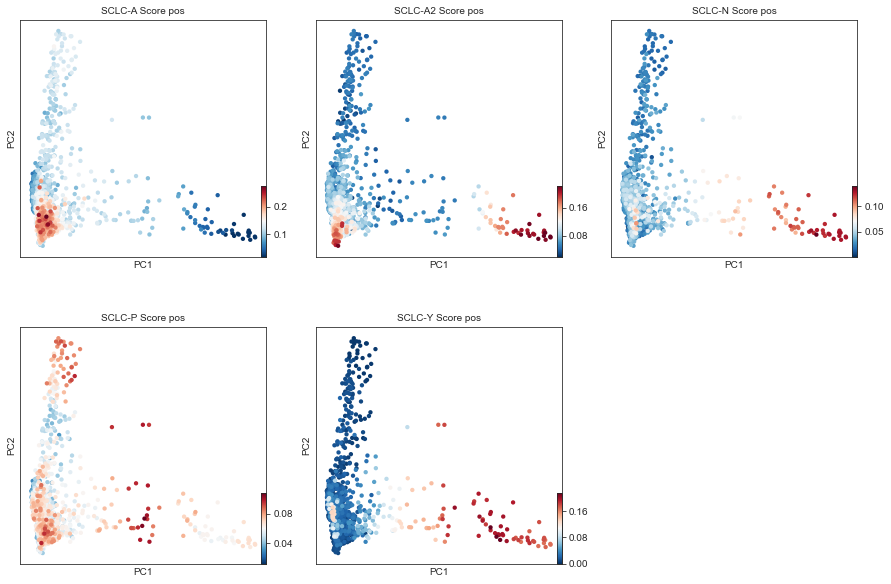

In [37]:
scv.pl.pca(X_magic, color = [i for i in adata.obs if '_Score_pos' in i], legend_loc = 'on right', cmap='RdBu_r',
            figsize= (5,5), frameon=True,
            ncols = 3, smooth = True)

In [38]:
X_magic.obsm['ParetoTI_S'].columns = X_magic.obsm['ParetoTI_S'].columns.astype(str)


[<AxesSubplot:title={'center':'S matrix score'}, xlabel='PC1', ylabel='PC2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='PC1', ylabel='PC2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='PC1', ylabel='PC2'>]

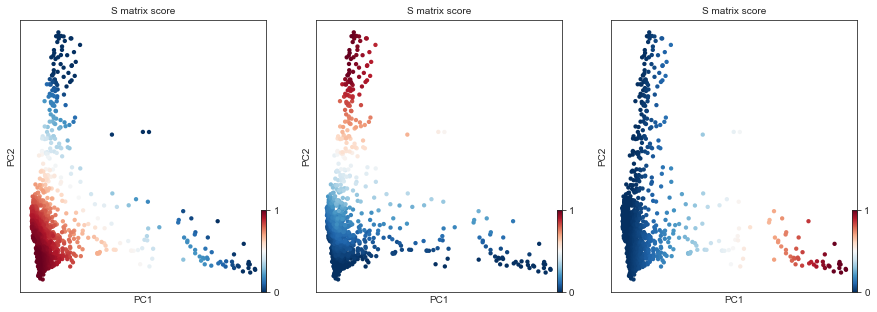

In [39]:
scv.pl.pca(X_magic, c = [X_magic.obsm['ParetoTI_S'][i] for i in X_magic.obsm['ParetoTI_S']], components='1,2', show=False, figsize= (5,5),ncols = 3, 
            title = 'S matrix score',
            frameon=True, cmap = 'RdBu_r')


In [40]:
adata.write_h5ad('../../out/human-tumors/adata_03b.h5ad')

In [41]:
X_magic.write_h5ad('../../out/human-tumors/X_magic_03b.h5ad')

## Enrichment of bulk archetype signatures using Permutation enrichment test

We want to follow the same pipeline as ParTI enrichment, so we need:
1. Distances to each archetype, to determine which bin to put cells into
2. Score for each cell that we want to test enrichment of (i.e. each signature score)
    1. We may want a cut-off of significance for the scores first (or a z score, for example), so that you can't get enrichment of insignificant scores
    2. For example, P may be "enriched" in one of the archetypes, but if the P score itself isn't significant, then its enrichment doesn't mean much.
3. We want to use  a Mann-Whitney test (with FDR corrected q < 0.1). We should split the data into 10 bins and test enrichment of the clsoest bin vs. the rest of the data. The closest bin should also be the maximum.

We want to make sure we sample cells from each timepoint to make sure we are sampling from the whole space (e.g. A and A2 are enriched in a lot just because A and A2 are undersampled, so the background distribution isn't biased)

In [60]:
X_magic

AnnData object with n_obs × n_vars = 1596 × 13593
    obs: 'SCLC-A_Score_pos', 'SCLC-A2_Score_pos', 'SCLC-N_Score_pos', 'SCLC-P_Score_pos', 'SCLC-Y_Score_pos', 'arc_aa_type', 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'tumor', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'PTPRC+', 'COL1A1+', 'pca_cutoff', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'specialists_pca_diffdist', 'specialists_ParetoTI_S', 'ParetoTI_specialists', 'subtype', 'subtype_labeled'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-Tumor 1', 'dropkick_coef-Tumor 2', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log

saving figure to file ./figures/scvelo_UMAP_phase.pdf


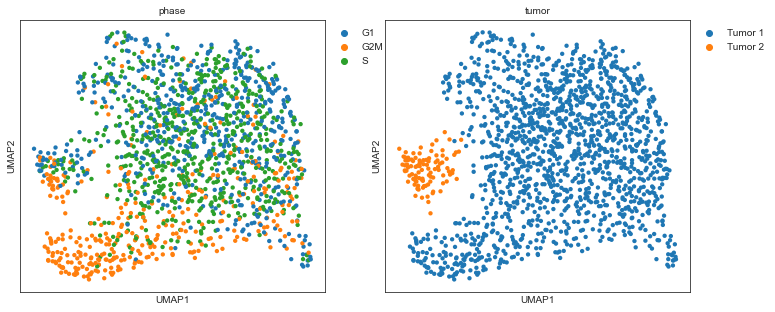

In [69]:
scv.pl.umap(adata, c = ['phase','tumor'], components='1,2', figsize= (6,5), frameon=True, cmap = 'RdBu', save ='UMAP_phase.pdf')


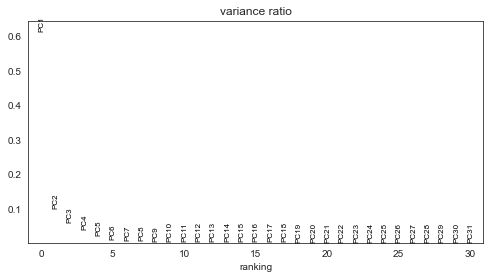

In [80]:
sc.pl.pca_variance_ratio(X_magic, save = 'variance_tumor_PCA.pdf')

saving figure to file ./figures/scvelo_phase_tumor.pdf


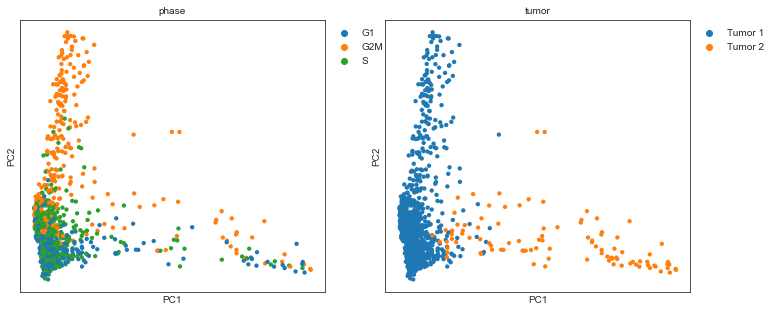

In [65]:
scv.pl.pca(X_magic, c = ['phase','tumor'], components='1,2', figsize= (6,5), frameon=True, cmap = 'RdBu', save = 'phase_tumor.pdf')


saving figure to file ./figures/scvelo_specialists_tumor.pdf


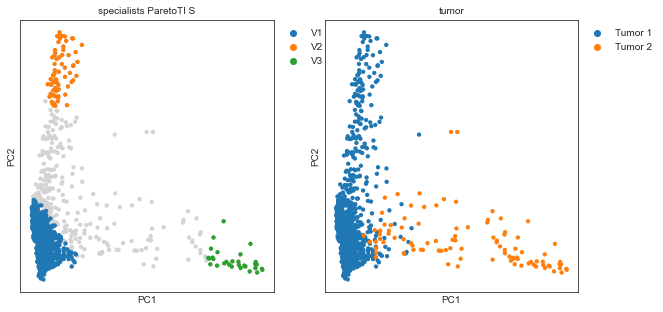

In [62]:
scv.pl.pca(X_magic, c = ['specialists_ParetoTI_S','tumor'], components='1,2', figsize= (5,5), frameon=True, cmap = 'RdBu', save = 'specialists_tumor.pdf')



saving figure to file ./figures/scvelo_bulk_score_umaps.png


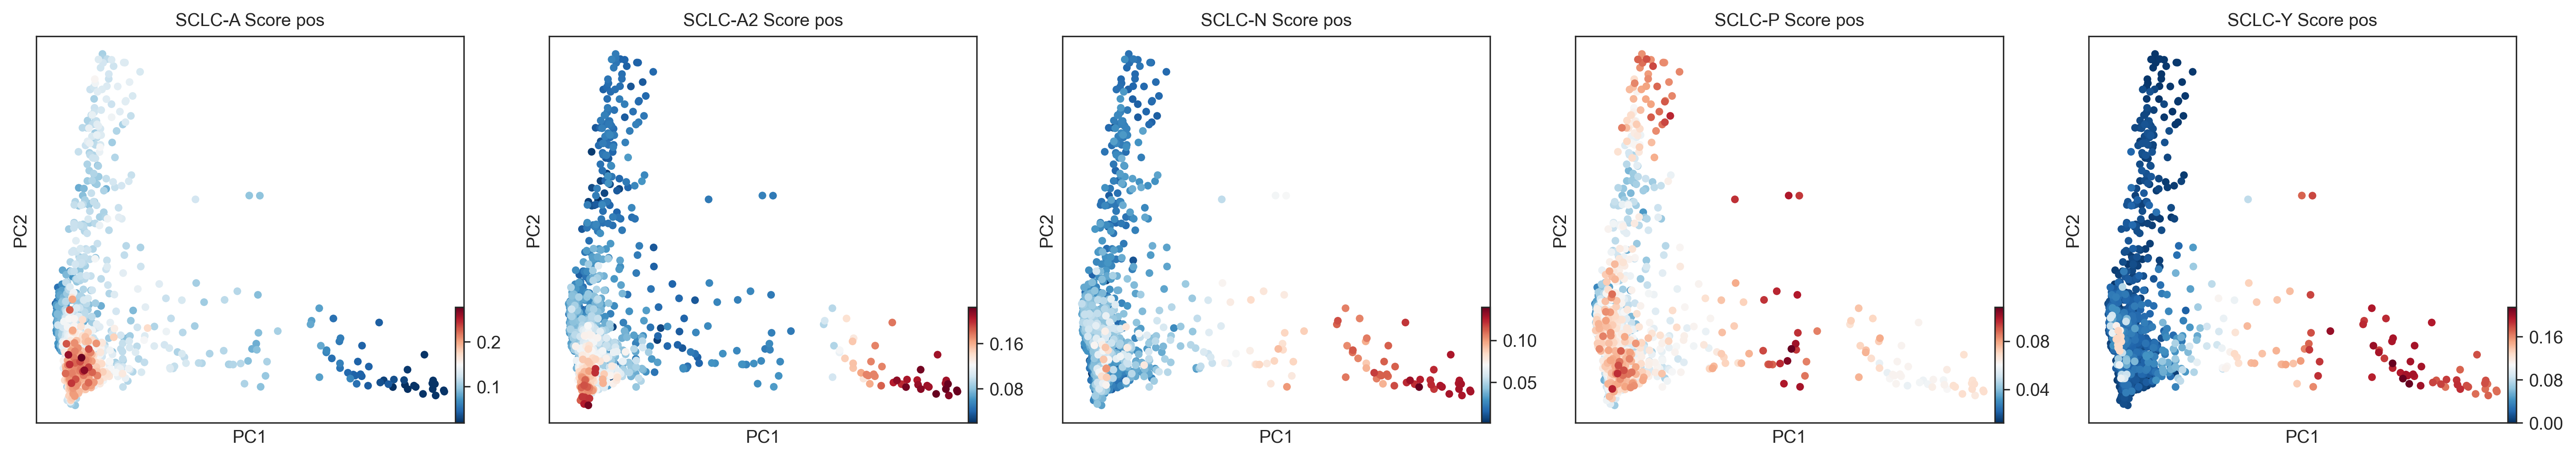

In [44]:
scv.pl.pca(X_magic, color = [i for i in X_magic.obs.columns if '_Score_pos' in i], legend_loc = 'on right', cmap='RdBu_r',
            figsize= (5,4), frameon=True, dpi = 300,
            ncols = 5, smooth = True, save = 'bulk_score_umaps.png')

In [45]:
X_magic.write_h5ad('../../out/human-tumors/X_magic_03b.h5ad')

In [46]:
X_magic

AnnData object with n_obs × n_vars = 1596 × 13593
    obs: 'SCLC-A_Score_pos', 'SCLC-A2_Score_pos', 'SCLC-N_Score_pos', 'SCLC-P_Score_pos', 'SCLC-Y_Score_pos', 'arc_aa_type', 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'tumor', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'PTPRC+', 'COL1A1+', 'pca_cutoff', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'specialists_pca_diffdist', 'specialists_ParetoTI_S'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-Tumor 1', 'dropkick_coef-Tumor 2', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts',

Archetype: V1


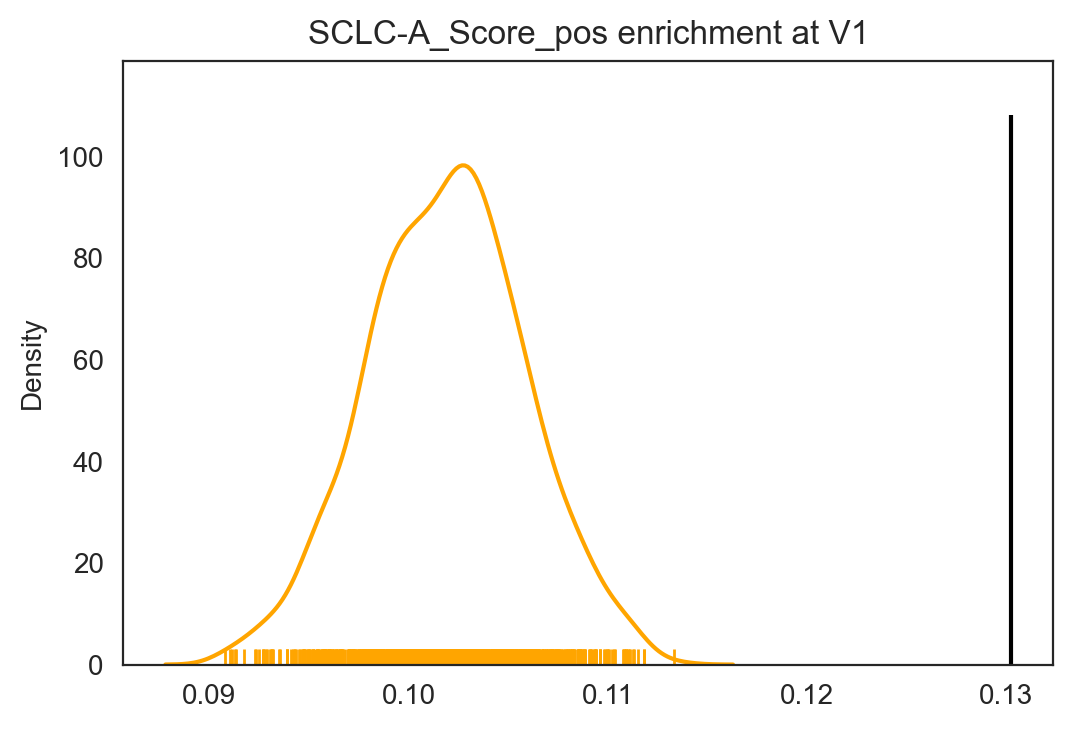

	 p-value for SCLC-A_Score_pos: 0.0


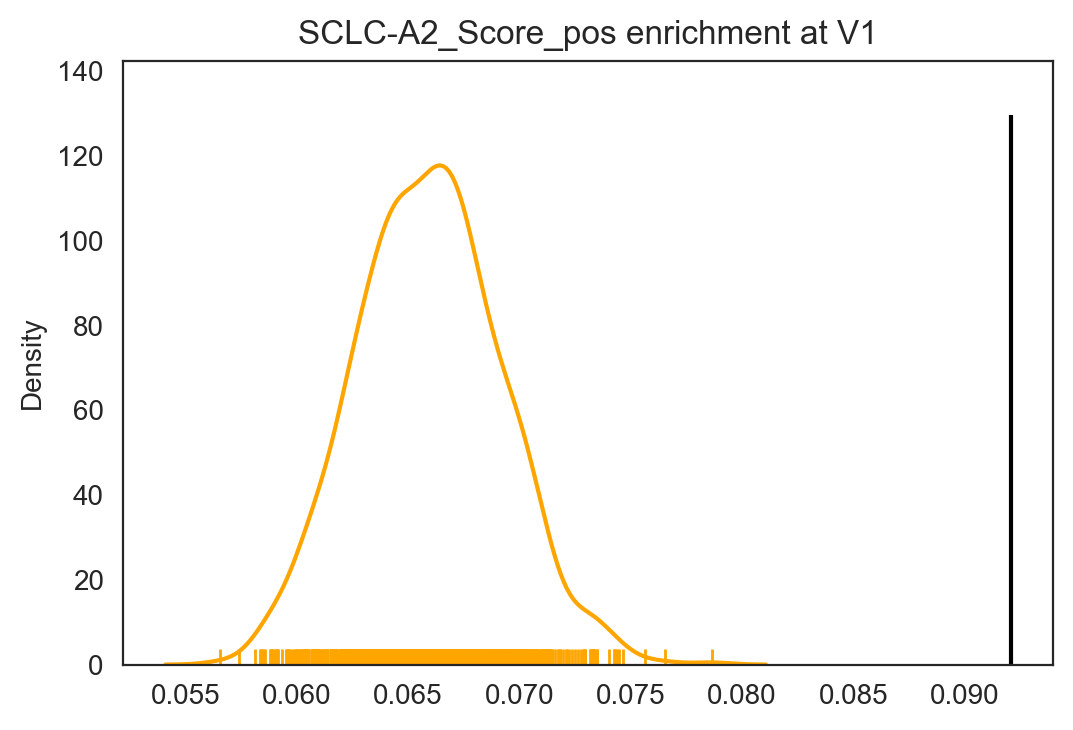

	 p-value for SCLC-A2_Score_pos: 0.0


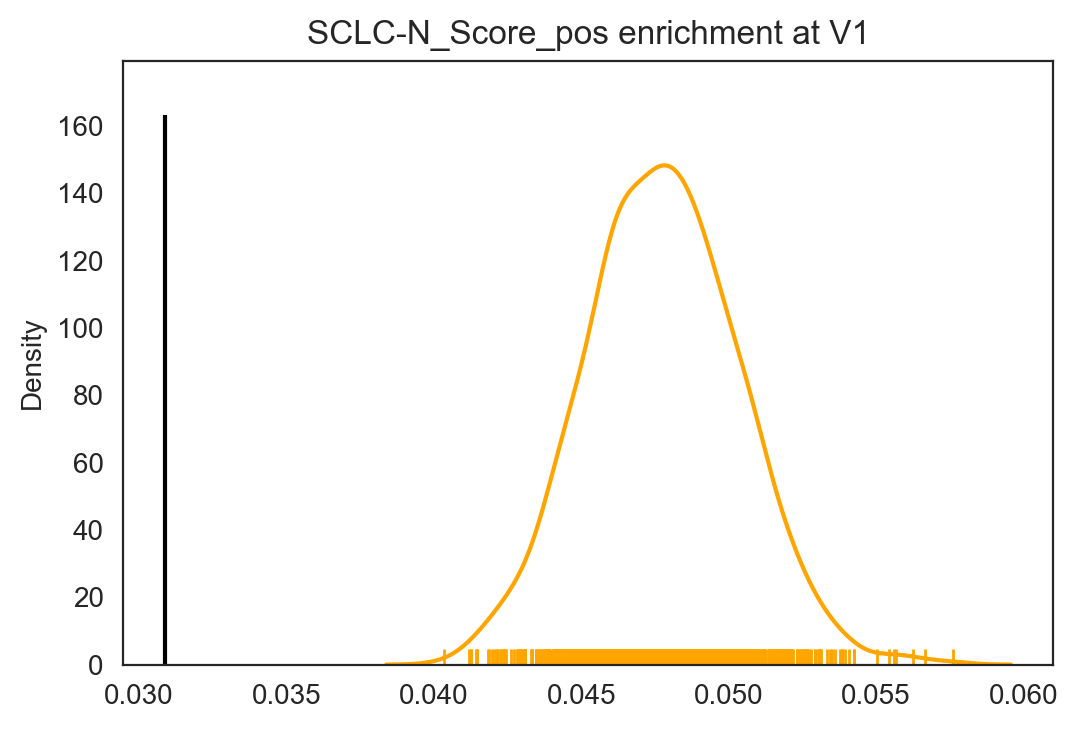

	 p-value for SCLC-N_Score_pos: 1.0


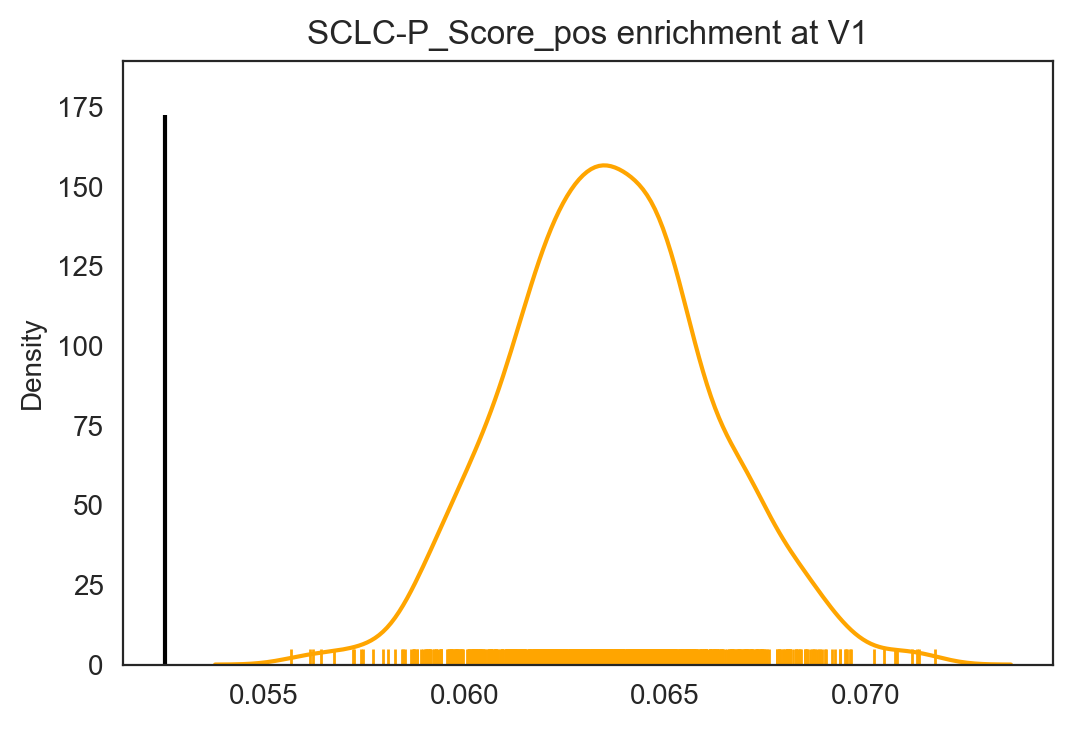

	 p-value for SCLC-P_Score_pos: 1.0


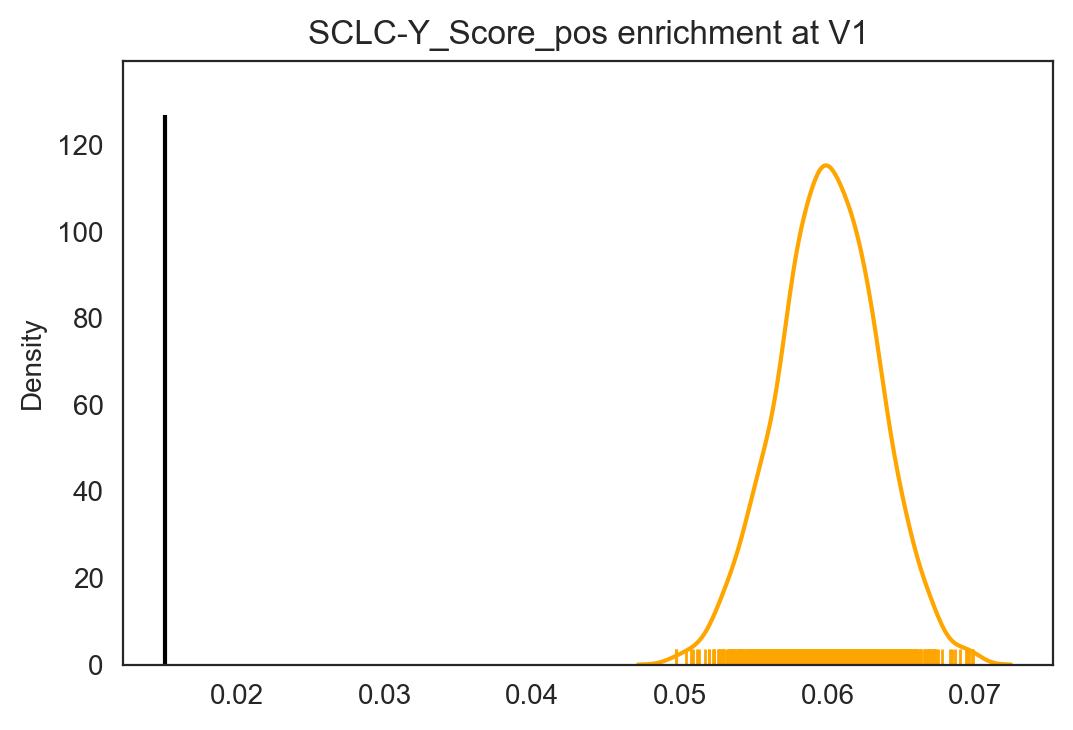

	 p-value for SCLC-Y_Score_pos: 1.0
Archetype: V2


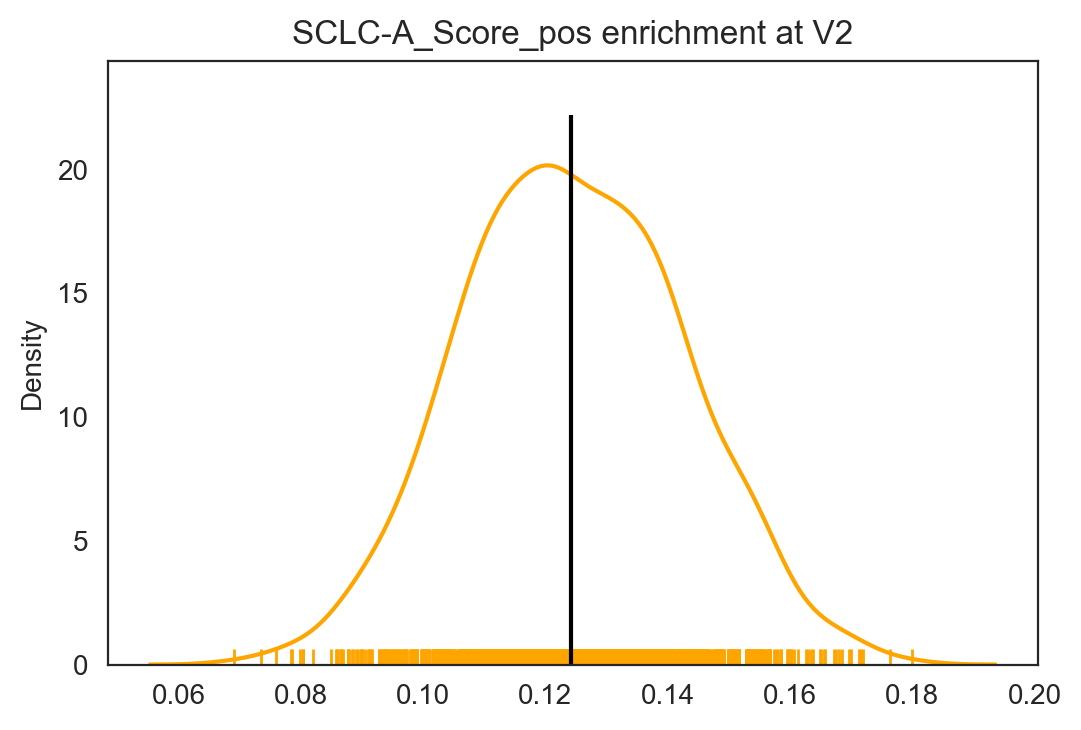

	 p-value for SCLC-A_Score_pos: 0.487


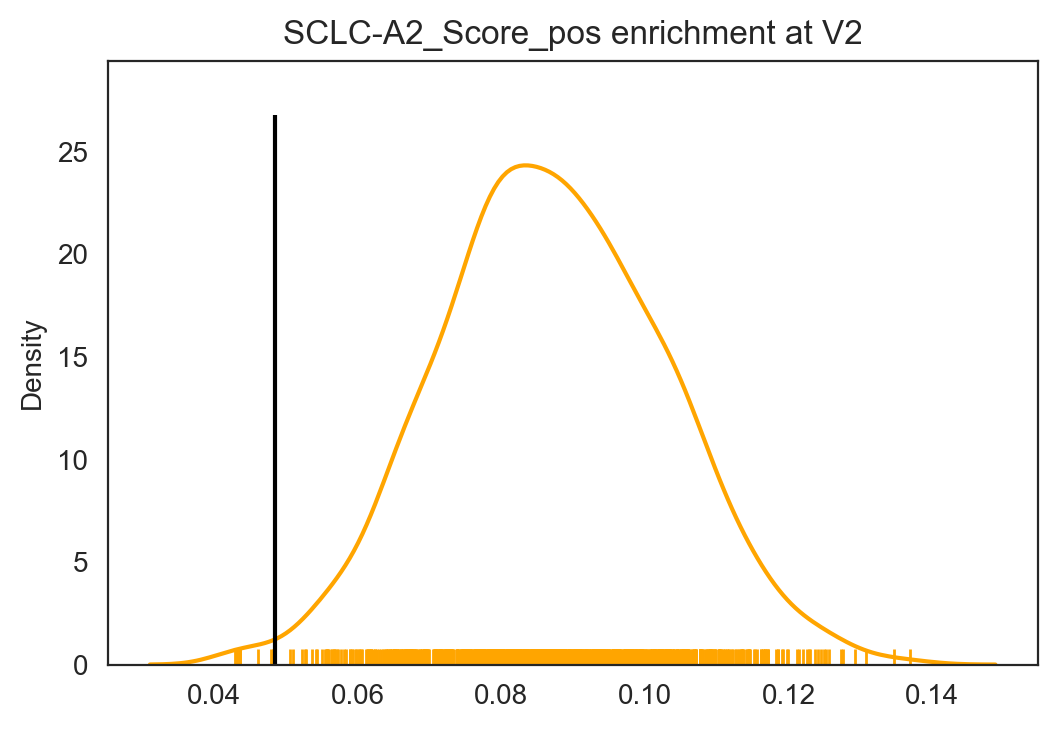

	 p-value for SCLC-A2_Score_pos: 0.992


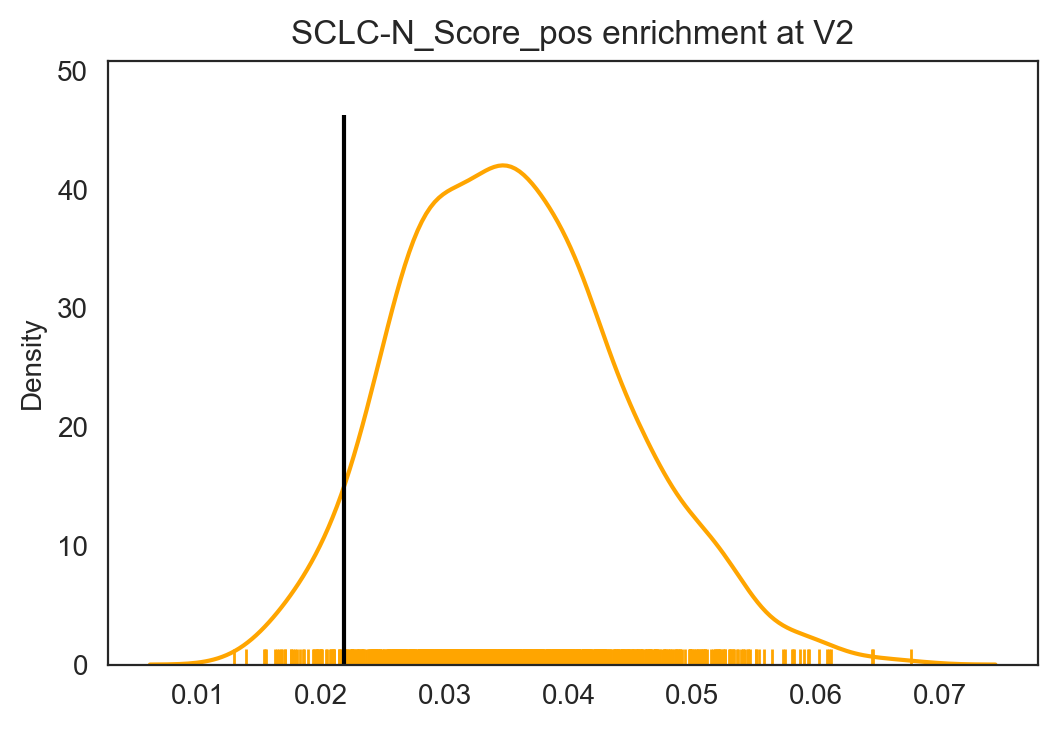

	 p-value for SCLC-N_Score_pos: 0.951


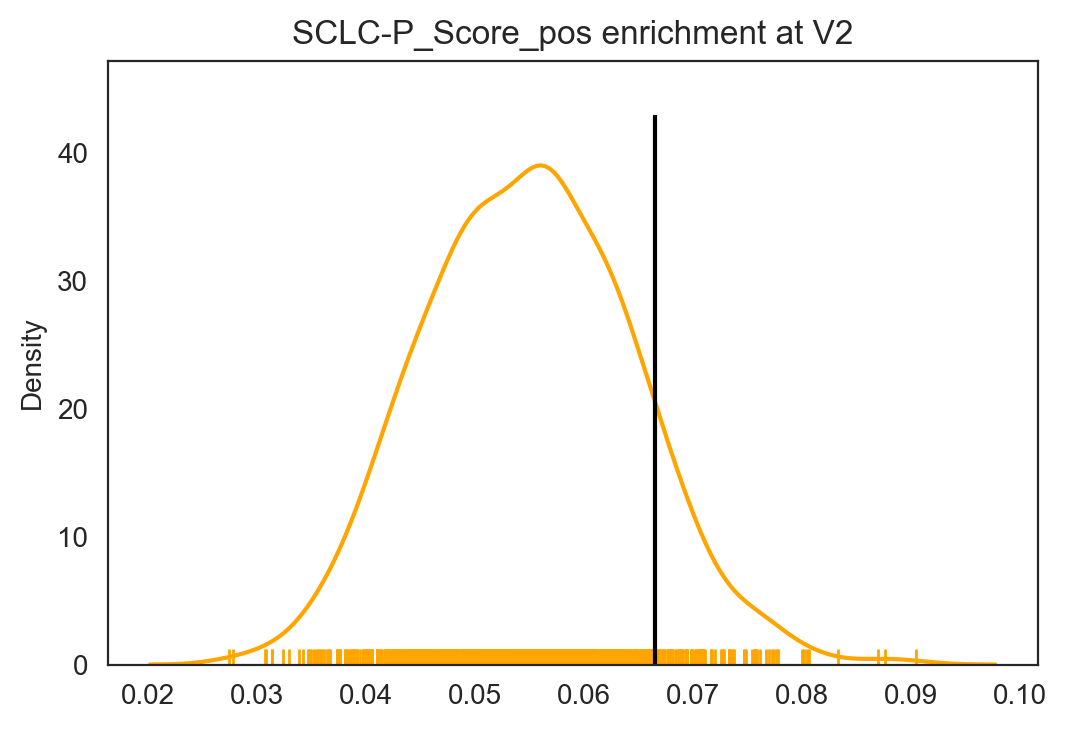

	 p-value for SCLC-P_Score_pos: 0.10699999999999998


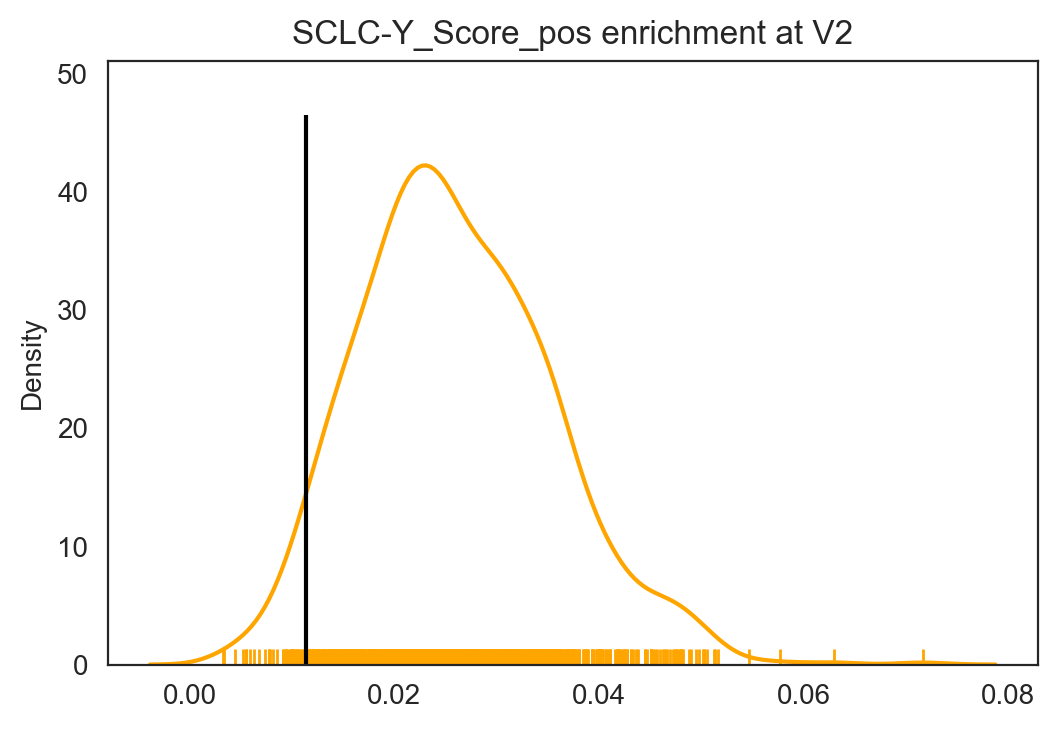

	 p-value for SCLC-Y_Score_pos: 0.961
Archetype: V3


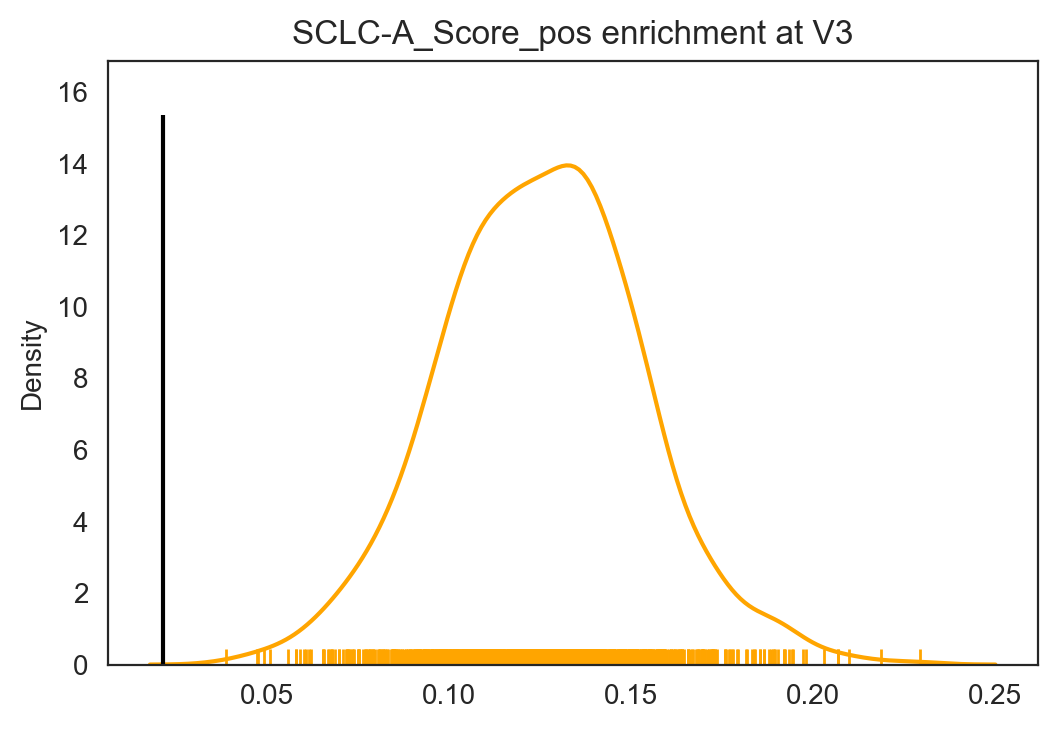

	 p-value for SCLC-A_Score_pos: 1.0


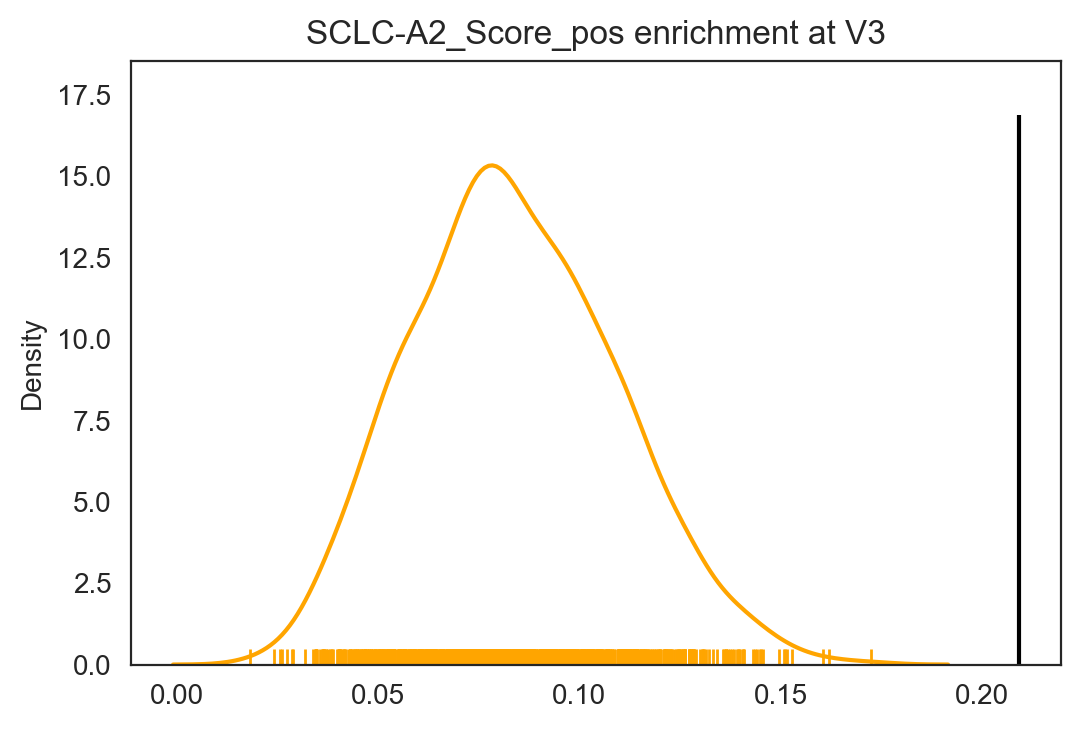

	 p-value for SCLC-A2_Score_pos: 0.0


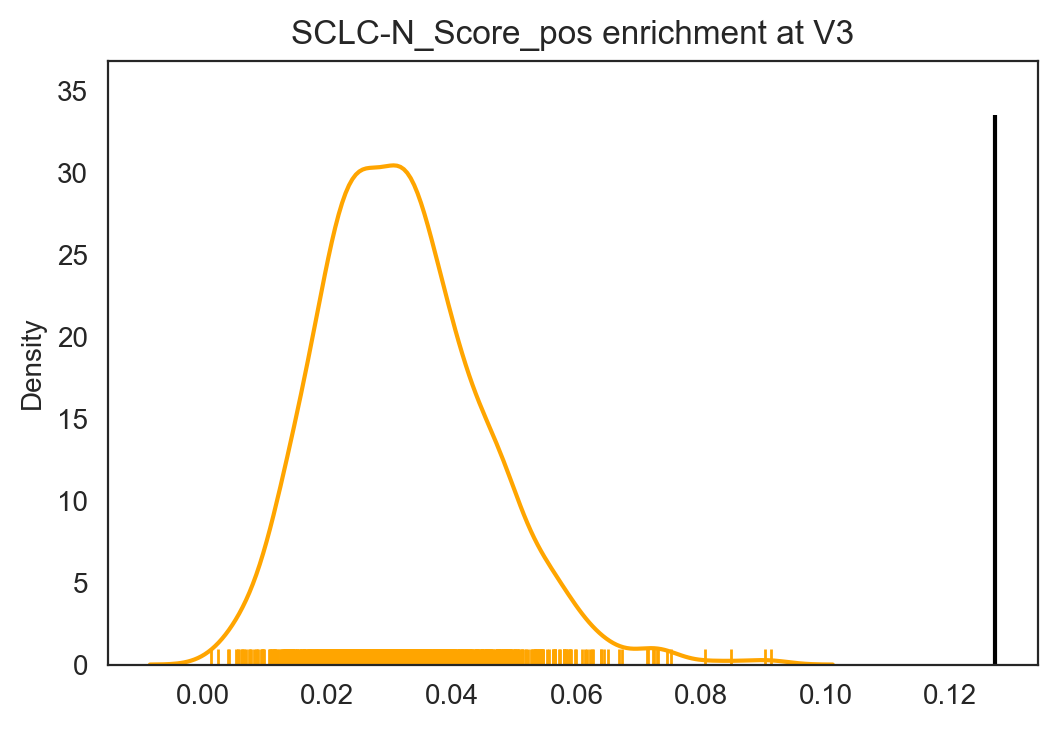

	 p-value for SCLC-N_Score_pos: 0.0


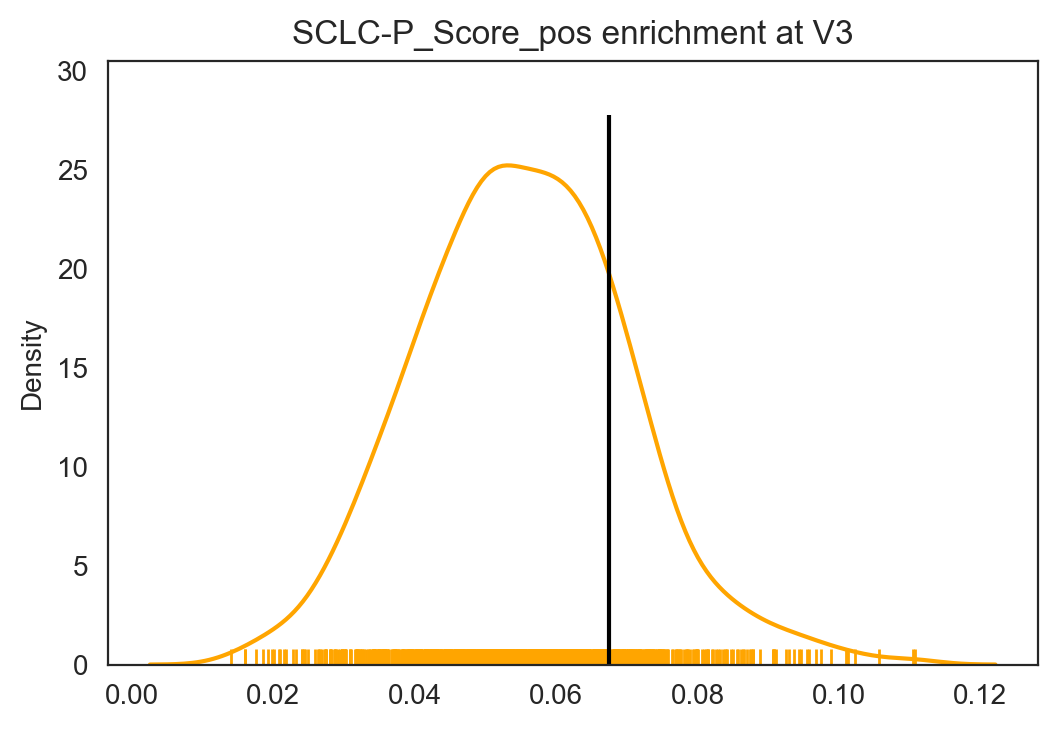

	 p-value for SCLC-P_Score_pos: 0.19099999999999995


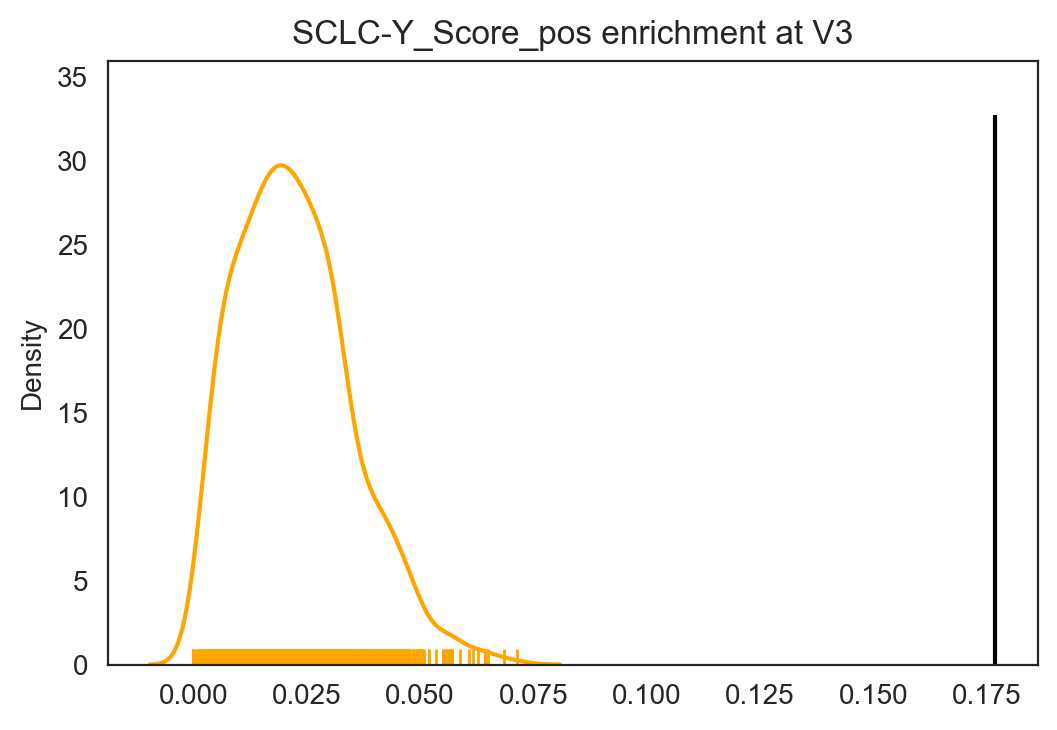

	 p-value for SCLC-Y_Score_pos: 0.0


In [47]:
score = X_magic.obs[[i for i in X_magic.obs if '_Score_pos' in i]]
score = score.fillna(0)
p_values_mean_corr, p_values_mean = mb.ar.permutation_enrichment_test(X_magic, score, plot = True, stat = 'mean', verbose = False, correction='holm', figsize = (6,4), save = 'enrichment.pdf')

In [48]:
p_values_mean_corr

variable SCLC-A2_Score_pos SCLC-A_Score_pos SCLC-N_Score_pos SCLC-P_Score_pos  \
id                                                                              
V1                     0.0              0.0                1                1   
V2                       1                1                1                1   
V3                     0.0                1              0.0                1   

variable SCLC-Y_Score_pos  
id                         
V1                      1  
V2                      1  
V3                    0.0

In [50]:
 X_magic.obs['ParetoTI_specialists'] = [{'V1':'A/A2',
 'V2':'None',
 'V3':'A2/N/Y',
 np.nan: np.nan}[i] for i in X_magic.obs.specialists_ParetoTI_S]
    

In [52]:
X_magic.uns['ParetoTI_specialists_colors'] = ['#F8766D','#E18A00','#BE9C00']



In [87]:
arc_pca = pd.read_csv('../../out/human-tumors/ParetoTI/arc_ave_positions_pca.csv', index_col=0)

In [88]:
arc_pca

V1         V2         V3
PC_1  -4.459932  -0.666253  45.681721
PC_2  -2.413204  12.036182  -2.026353
PC_3   0.004019  -0.495937   1.534576
PC_4  -0.013213   0.087811   0.012265
PC_5   0.056290  -0.263887  -0.391662
PC_6  -0.017515  -0.006607   0.303202
PC_7   0.007236  -0.003818  -0.109502
PC_8  -0.000873  -0.076849   0.099886
PC_9   0.057804  -0.200781  -0.371624
PC_10 -0.025576   0.058834   0.246545
PC_11  0.001292  -0.036806   0.178485

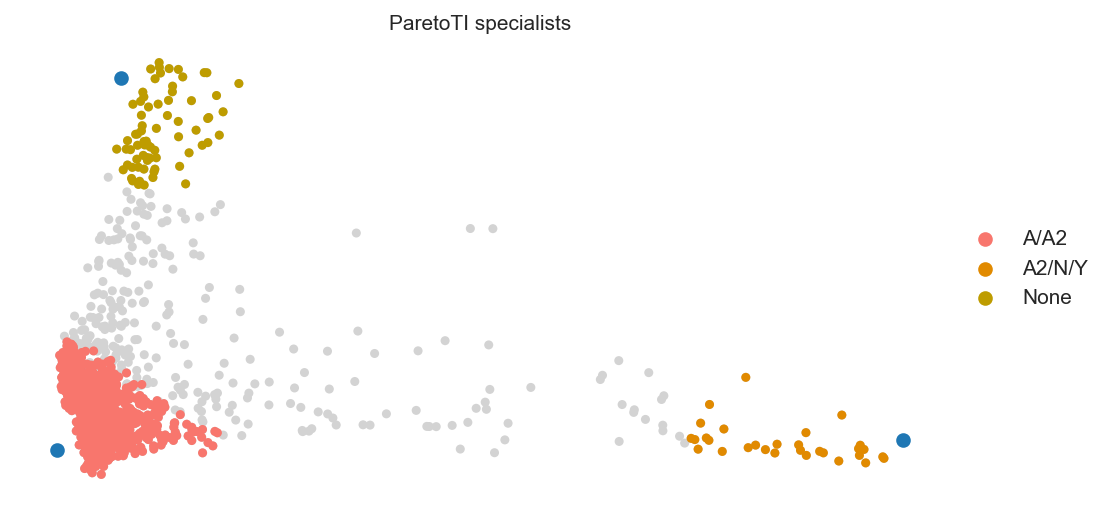

In [89]:
scv.pl.pca(X_magic, color = ['ParetoTI_specialists'], legend_loc = 'on right', dpi = 150, show = False)
plt.scatter(arc_pca.loc['PC_1'], arc_pca.loc['PC_2'])


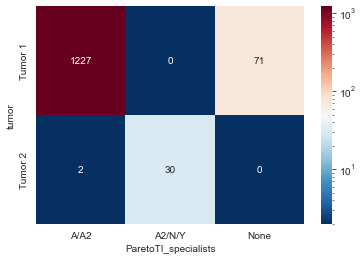

In [55]:
from matplotlib.colors import LogNorm, Normalize

sns.heatmap(pd.crosstab(X_magic.obs.tumor, X_magic.obs.ParetoTI_specialists)[['A/A2','A2/N/Y','None']], annot=True,
            norm=LogNorm(clip = True), fmt = 'd', cmap = 'RdBu_r')
plt.savefig('./figures/heatmap_ParetoTI-specialists_timepoints.pdf')


In [56]:
X_magic.write_h5ad('../../out/human-tumors/X_magic_03b.h5ad')


In [22]:
X_magic.obs['subtype'] =X_magic.obs.specialists_ParetoTI_S

X_magic.obs.subtype = [str(i) for i in X_magic.obs.subtype]

new = []
for i in X_magic.obs.subtype:
    if i == 'nan':
        new.append("Generalist")
    else:
        new.append("Archetype "+str(i))

X_magic.obs.subtype = new

In [23]:
X_magic.obs['subtype_labeled'] =X_magic.obs.ParetoTI_specialists

X_magic.obs.subtype_labeled = [str(i) for i in X_magic.obs.subtype_labeled]

new = []
for i in X_magic.obs.subtype_labeled:
    if i == 'nan':
        new.append("Generalist")
    else:
        new.append(str(i))

X_magic.obs.subtype_labeled = new

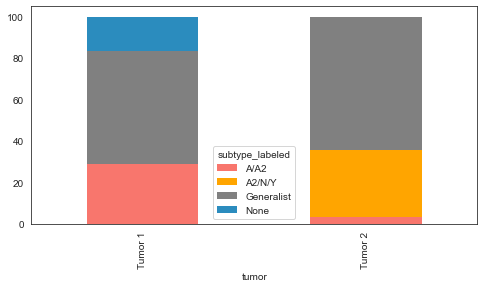

In [26]:
# cp = ['#fc8d62', '#66c2a5', '#FFD43B', '#8da0cb', '#e78ac3']
# color_dict = {'Archetype 3': cp[4], 'Archetype 5': cp[0], 'Archetype 4': cp[1], 'Archetype 2': cp[2], 'Archetype 1': cp[3],
#               'Generalist': 'darkgrey', 'Unclassified': 'lightgrey'}
mb.pl.subtype_bar(X_magic,groupby='tumor', fname = 'human_tumor', pheno_name="subtype_labeled", custom_palette=['#F8766D','orange','grey','#2b8cbe','gold','#2ca25f'])

# PCHA subtyping

In [3]:
X_magic = sc.read_h5ad('../../out/human-tumors/X_magic_cc_03b.h5ad')

In [4]:
S_matrix = pd.read_csv('../../out/human-tumors/ParetoTI/S_cc.csv', index_col=0)

In [5]:
S_matrix

V1        V2  \
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.000000  0.978596   
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.108298  0.891702   
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.347685  0.640646   
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.470297  0.441921   
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.558494  0.293505   
...                                                      ...       ...   
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TGAGCGCATTCCCCT...  0.462032  0.060033   
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TGAGGGAAATCACCA...  0.000000  0.000000   
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TTATAGCCGACAACT...  0.640596  0.000000   
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TTTGTGTCCCTACTA...  0.019443  0.000000   
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TGGTATGACCCTAAC...  0.211308  0.000000   

                                                          V3  
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.021404  
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.000000  
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.011669  
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.087782  
/scratch/h_vangard_1/daix4/Ken/20200121_indropv...  0.148001  
...                                                      ...  
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TGAGCGCATTCCCCT...  0.477935  
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TGAGGGAAATCACCA...  1.000000  
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TTATAGCCGACAACT...  0.359404  
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TTTGTGTCCCTACTA...  0.980557  
3359-PK-1-GCCAAT-ATCAGT_S1_L001:TGGTATGACCCTAAC...  0.788692  

[1596 rows x 3 columns]

[<AxesSubplot:xlabel='PC1', ylabel='PC2'>,
 <AxesSubplot:xlabel='PC1', ylabel='PC2'>,
 <AxesSubplot:xlabel='PC1', ylabel='PC2'>]

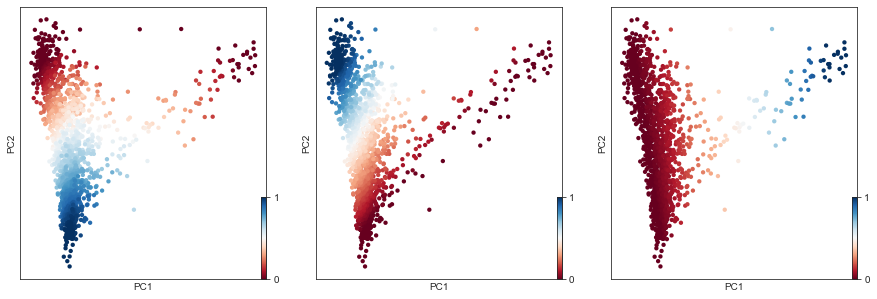

In [6]:
scv.pl.pca(X_magic, c = [S_matrix[i] for i in ['V1','V2','V3']], components='1,2', show=False, figsize= (5,5),ncols = 3, frameon=True, cmap = 'RdBu')


In [7]:
X_magic.obsm['ParetoTI_S'] = S_matrix

In [8]:
tmp = X_magic.obsm['ParetoTI_S'].copy()

for arc in  X_magic.obsm['ParetoTI_S'].columns:
    closest = X_magic.obsm['ParetoTI_S'].loc[X_magic.obsm['ParetoTI_S'][arc].sort_values(ascending = False) > .8]
    tmp.loc[closest.index,'specialist'] = arc
X_magic.obs['specialists_ParetoTI_S'] = tmp.specialist
X_magic.obs['specialists_ParetoTI_S'].value_counts()

V1    436
V2    251
V3     32
Name: specialists_ParetoTI_S, dtype: int64

saving figure to file ./figures/scvelo_tumors_arc.pdf


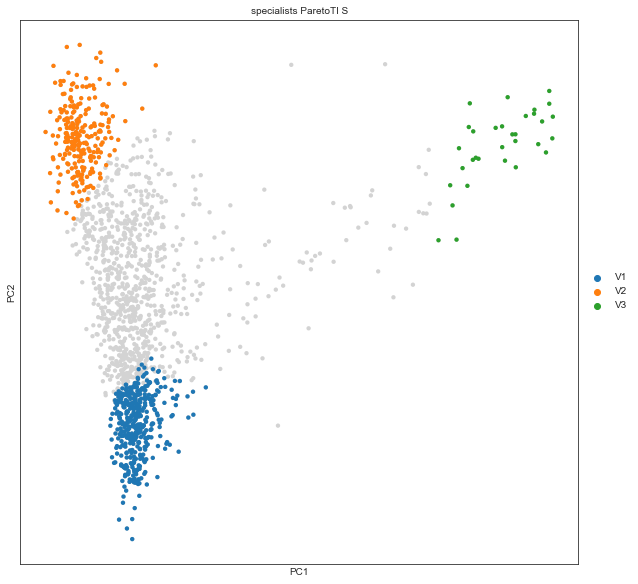

In [10]:
scv.pl.pca(X_magic, color = 'specialists_ParetoTI_S', figsize= (10,10), frameon=True, legend_loc = 'on right', save = 'tumors_arc.pdf')


In [97]:
X_magic.obs = pd.merge(adata.obs.arc_aa_type,X_magic.obs, left_index=True, right_index=True)

In [98]:
X_magic.obs = pd.merge(adata.obs[[i for i in adata.obs if '_Score_pos' in i]],X_magic.obs, left_index=True, right_index=True)

In [99]:
X_magic.obs = X_magic.obs.fillna({i:0 for i in adata.obs if '_Score_pos' in i})

In [100]:
scv.pp.neighbors(X_magic)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


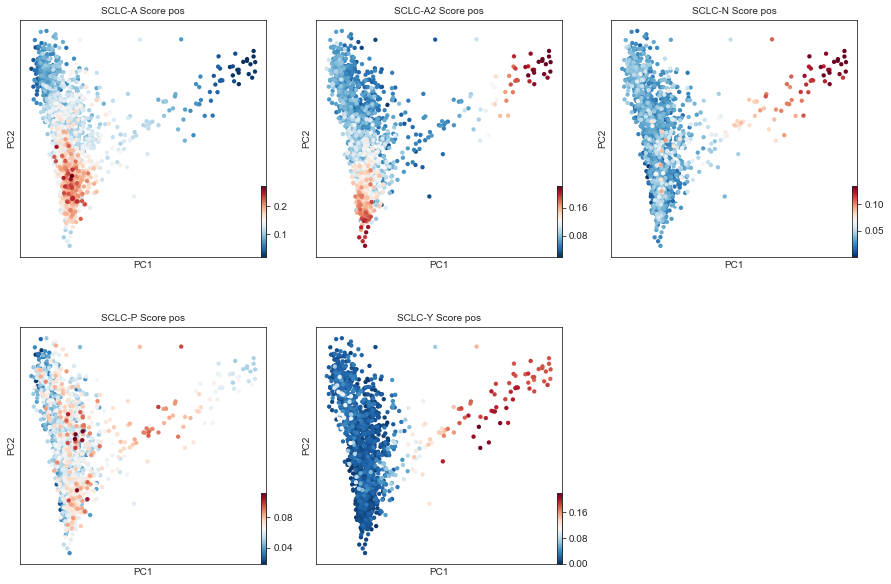

In [101]:
scv.pl.pca(X_magic, color = [i for i in adata.obs if '_Score_pos' in i], legend_loc = 'on right', cmap='RdBu_r',
            figsize= (5,5), frameon=True,
            ncols = 5, smooth = True, save)

In [102]:
X_magic.obsm['ParetoTI_S'].columns = X_magic.obsm['ParetoTI_S'].columns.astype(str)


[<AxesSubplot:title={'center':'S matrix score'}, xlabel='PC1', ylabel='PC2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='PC1', ylabel='PC2'>,
 <AxesSubplot:title={'center':'S matrix score'}, xlabel='PC1', ylabel='PC2'>]

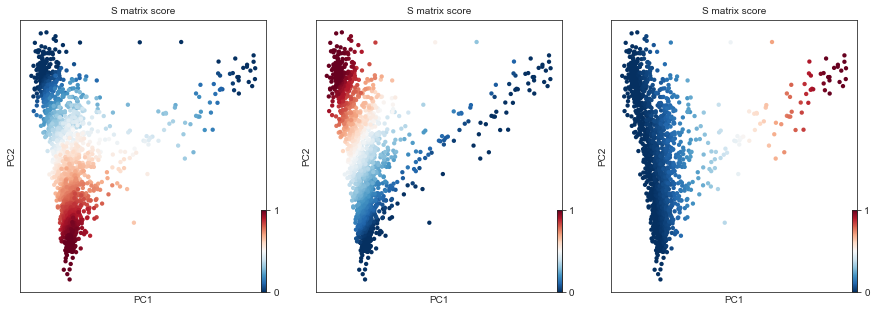

In [103]:
scv.pl.pca(X_magic, c = [X_magic.obsm['ParetoTI_S'][i] for i in X_magic.obsm['ParetoTI_S']], components='1,2', show=False, figsize= (5,5),ncols = 3, 
            title = 'S matrix score',
            frameon=True, cmap = 'RdBu_r')


In [104]:
X_magic.write_h5ad('../../out/human-tumors/X_magic_cc_03b.h5ad')

## Enrichment of bulk archetype signatures using Permutation enrichment test

We want to follow the same pipeline as ParTI enrichment, so we need:
1. Distances to each archetype, to determine which bin to put cells into
2. Score for each cell that we want to test enrichment of (i.e. each signature score)
    1. We may want a cut-off of significance for the scores first (or a z score, for example), so that you can't get enrichment of insignificant scores
    2. For example, P may be "enriched" in one of the archetypes, but if the P score itself isn't significant, then its enrichment doesn't mean much.
3. We want to use  a Mann-Whitney test (with FDR corrected q < 0.1). We should split the data into 10 bins and test enrichment of the clsoest bin vs. the rest of the data. The closest bin should also be the maximum.

We want to make sure we sample cells from each timepoint to make sure we are sampling from the whole space (e.g. A and A2 are enriched in a lot just because A and A2 are undersampled, so the background distribution isn't biased)

In [105]:
X_magic

AnnData object with n_obs × n_vars = 1596 × 13593
    obs: 'SCLC-A_Score_pos', 'SCLC-A2_Score_pos', 'SCLC-N_Score_pos', 'SCLC-P_Score_pos', 'SCLC-Y_Score_pos', 'arc_aa_type', 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'tumor', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'PTPRC+', 'COL1A1+', 'pca_cutoff', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'specialists_pca_diffdist', 'specialists_ParetoTI_S'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-Tumor 1', 'dropkick_coef-Tumor 2', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts',

saving figure to file ./figures/scvelo_phase_tumor.pdf


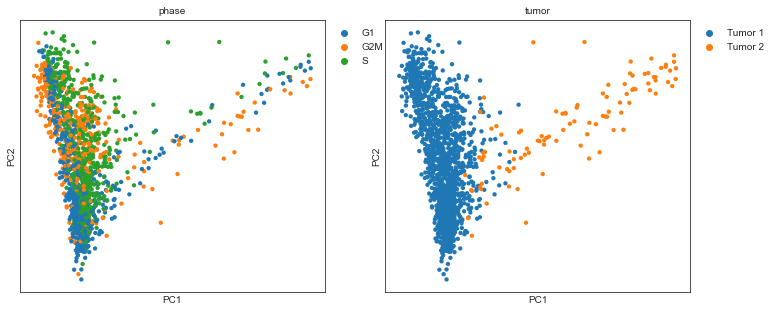

In [11]:
scv.pl.pca(X_magic, c = ['phase','tumor'], components='1,2', figsize= (6,5), frameon=True, cmap = 'RdBu', save = 'phase_tumor.pdf')


saving figure to file ./figures/scvelo_specialists_tumor.pdf


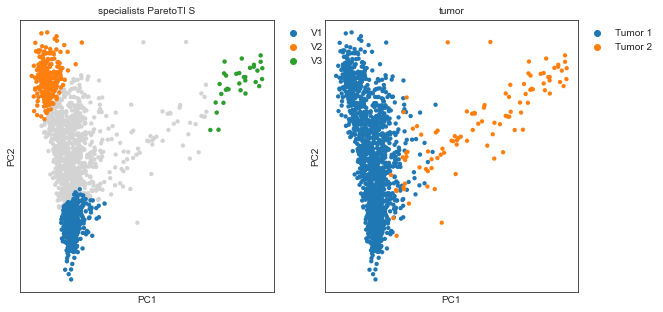

In [16]:
scv.pl.pca(X_magic, c = ['specialists_ParetoTI_S','tumor'], components='1,2', figsize= (5,5), frameon=True, cmap = 'RdBu', save = 'specialists_tumor.pdf')



saving figure to file ./figures/scvelo_bulk_score_umaps.png


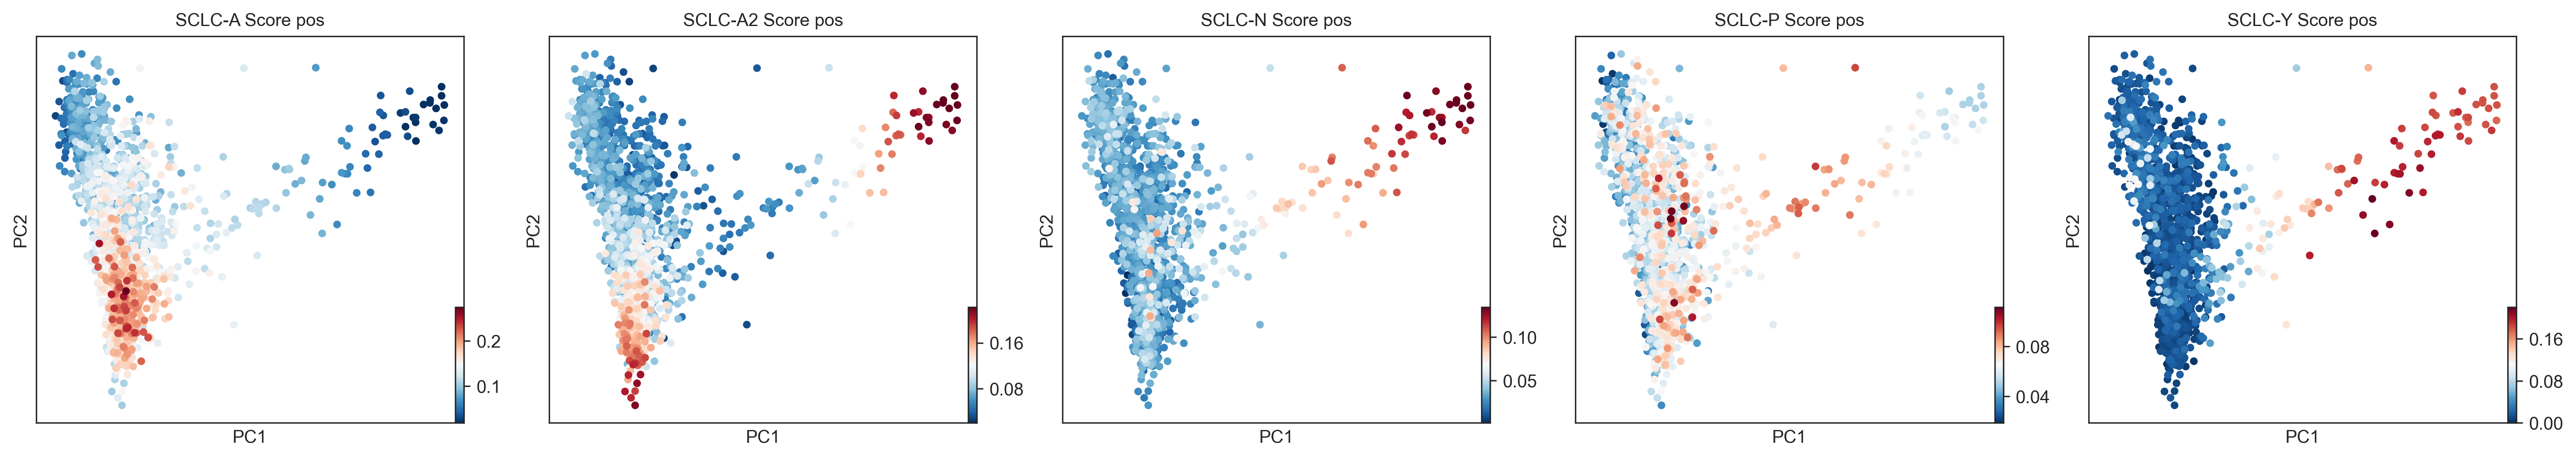

In [13]:
scv.pl.pca(X_magic, color = [i for i in X_magic.obs.columns if '_Score_pos' in i], legend_loc = 'on right', cmap='RdBu_r',
            figsize= (5,4), frameon=True, dpi = 300,
            ncols = 5, smooth = True, save = 'bulk_score_umaps.png')

In [111]:
X_magic.write_h5ad('../../out/human-tumors/X_magic_cc_03b.h5ad')

In [112]:
X_magic

AnnData object with n_obs × n_vars = 1596 × 13593
    obs: 'SCLC-A_Score_pos', 'SCLC-A2_Score_pos', 'SCLC-N_Score_pos', 'SCLC-P_Score_pos', 'SCLC-Y_Score_pos', 'arc_aa_type', 'dropkick_score', 'dropkick_label', 'arcsinh_n_genes_by_counts', 'tumor', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ambient', 'log1p_total_counts_ambient', 'pct_counts_ambient', 'arcsinh_total_counts', 'S_score', 'G2M_score', 'phase', 'leiden', 'PTPRC+', 'COL1A1+', 'pca_cutoff', 'M', 'E', 'clusters_gradients', 'cell_cycle_diff', 'specialists_pca_diffdist', 'specialists_ParetoTI_S'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'dropkick_coef-Tumor 1', 'dropkick_coef-Tumor 2', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'total_counts', 'log1p_total_counts',

Archetype: V1


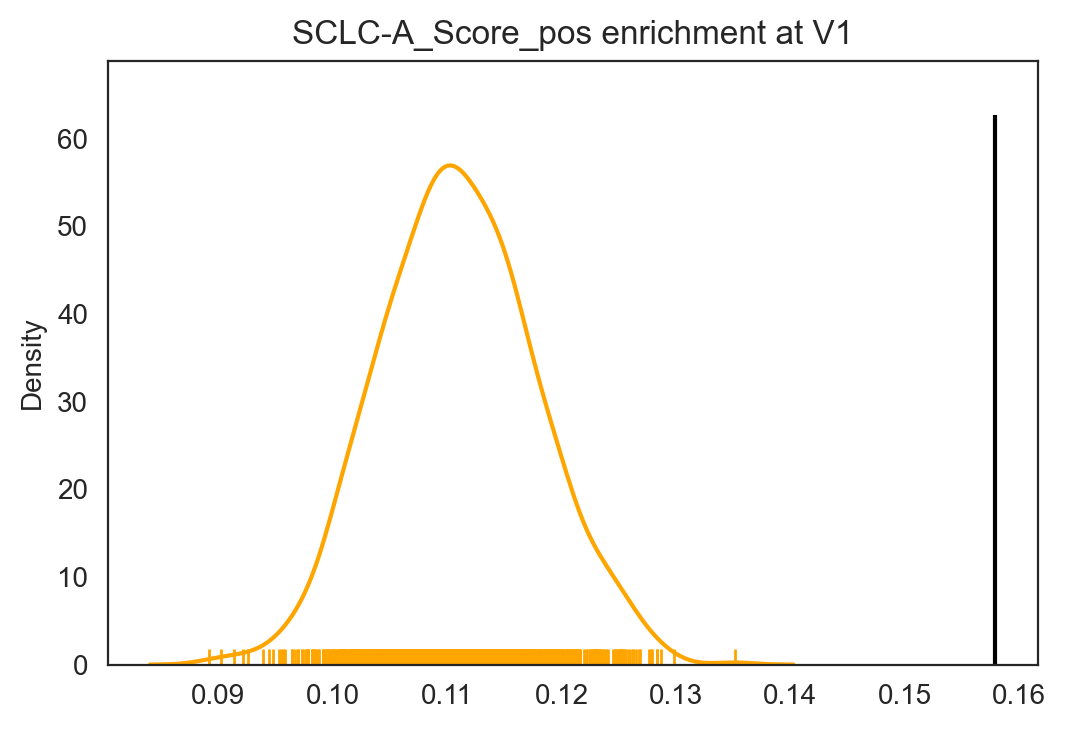

	 p-value for SCLC-A_Score_pos: 0.0


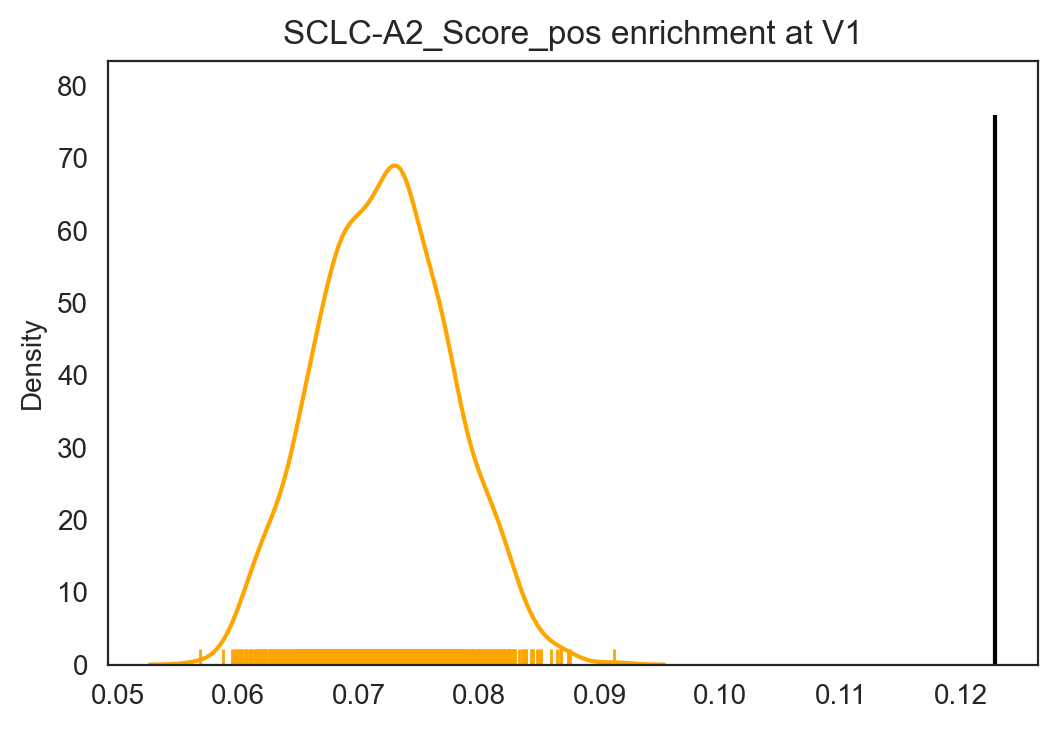

	 p-value for SCLC-A2_Score_pos: 0.0


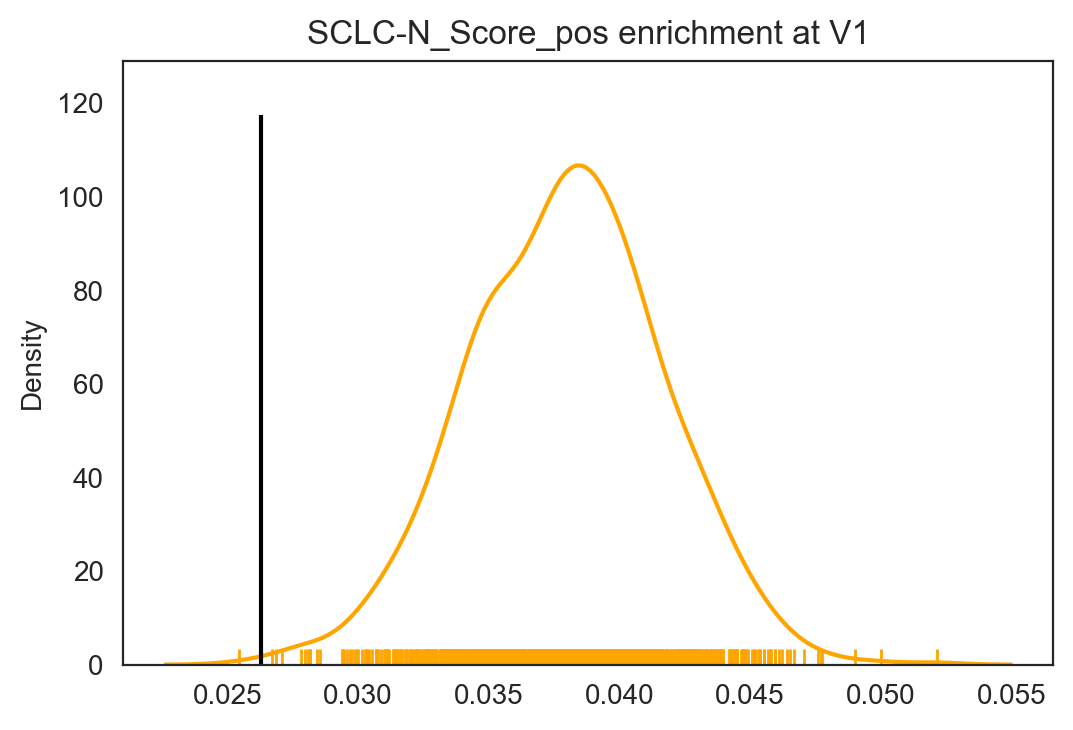

	 p-value for SCLC-N_Score_pos: 0.999


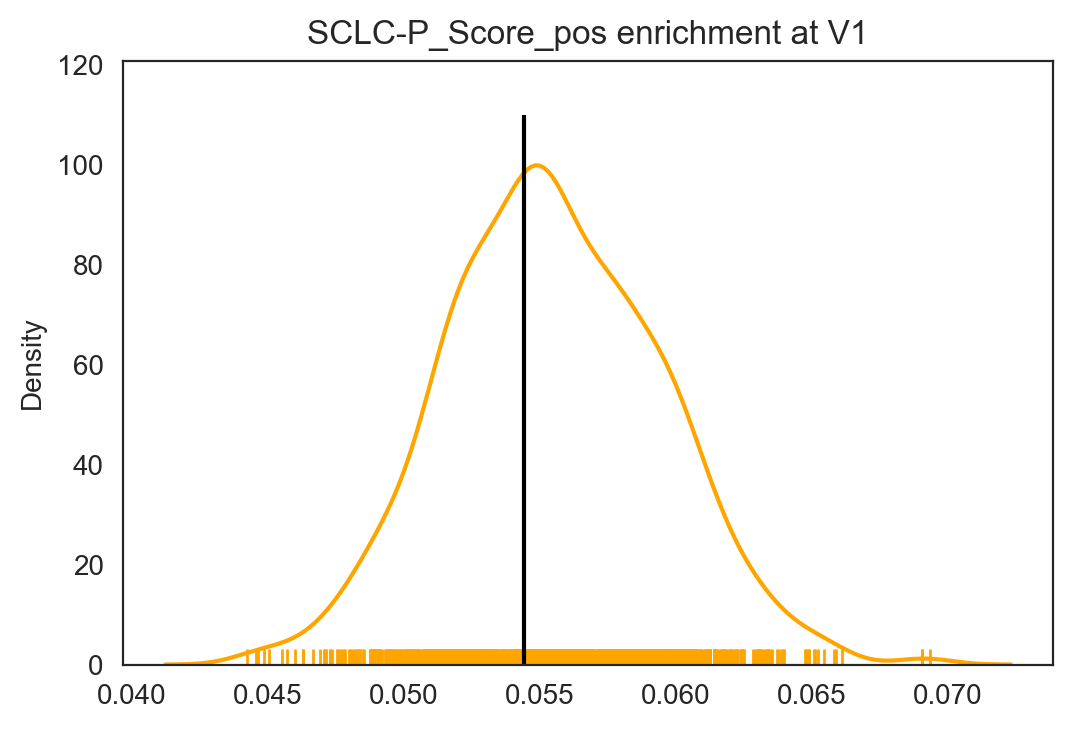

	 p-value for SCLC-P_Score_pos: 0.605


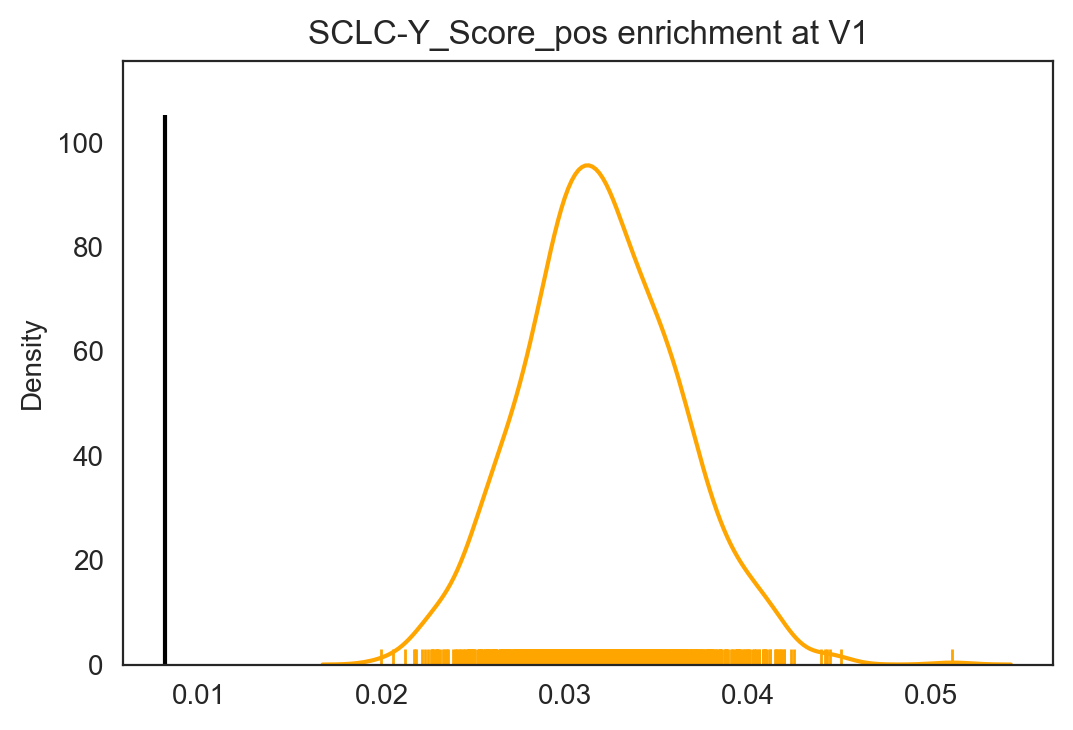

	 p-value for SCLC-Y_Score_pos: 1.0
Archetype: V2


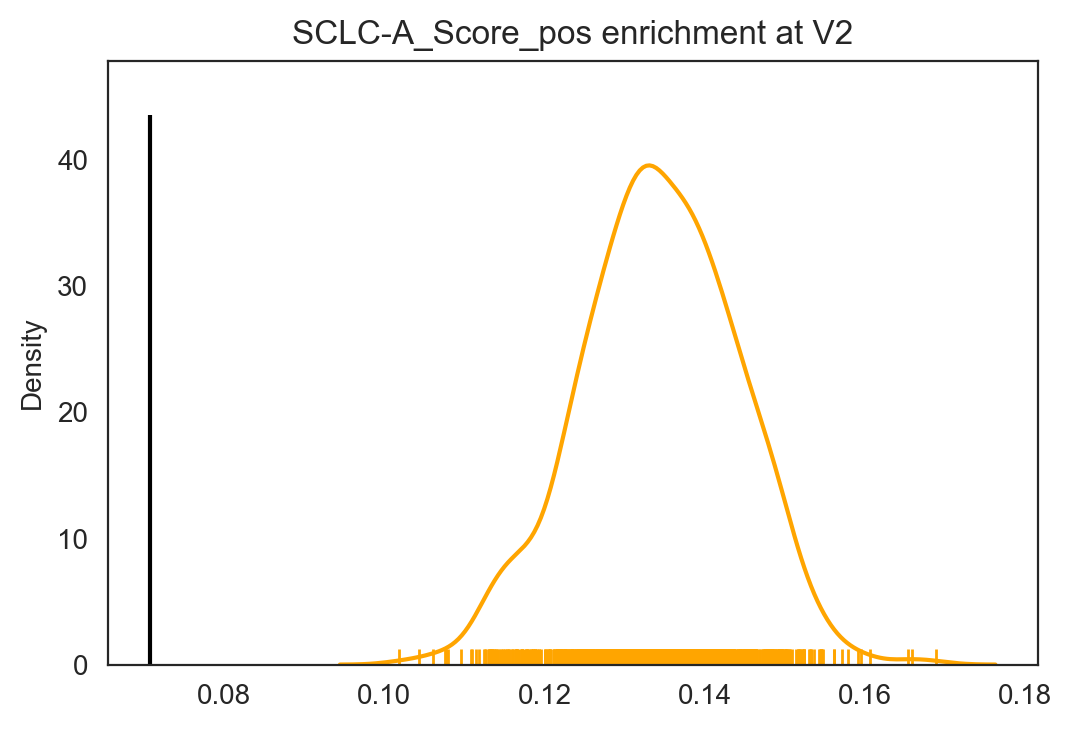

	 p-value for SCLC-A_Score_pos: 1.0


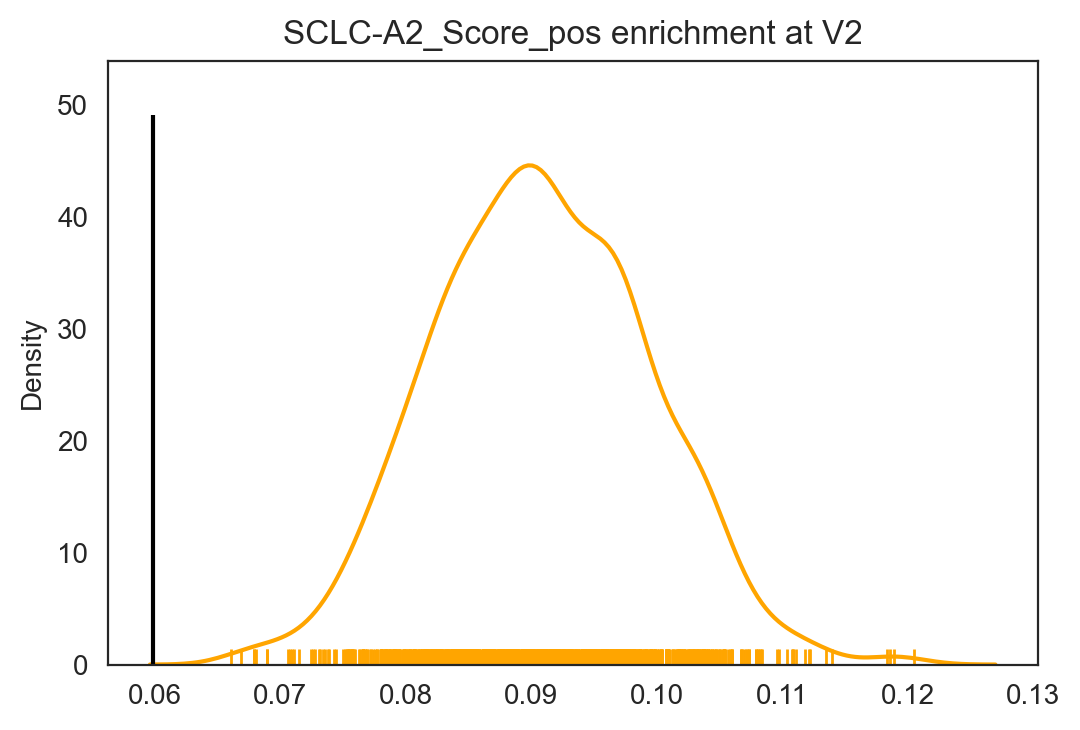

	 p-value for SCLC-A2_Score_pos: 1.0


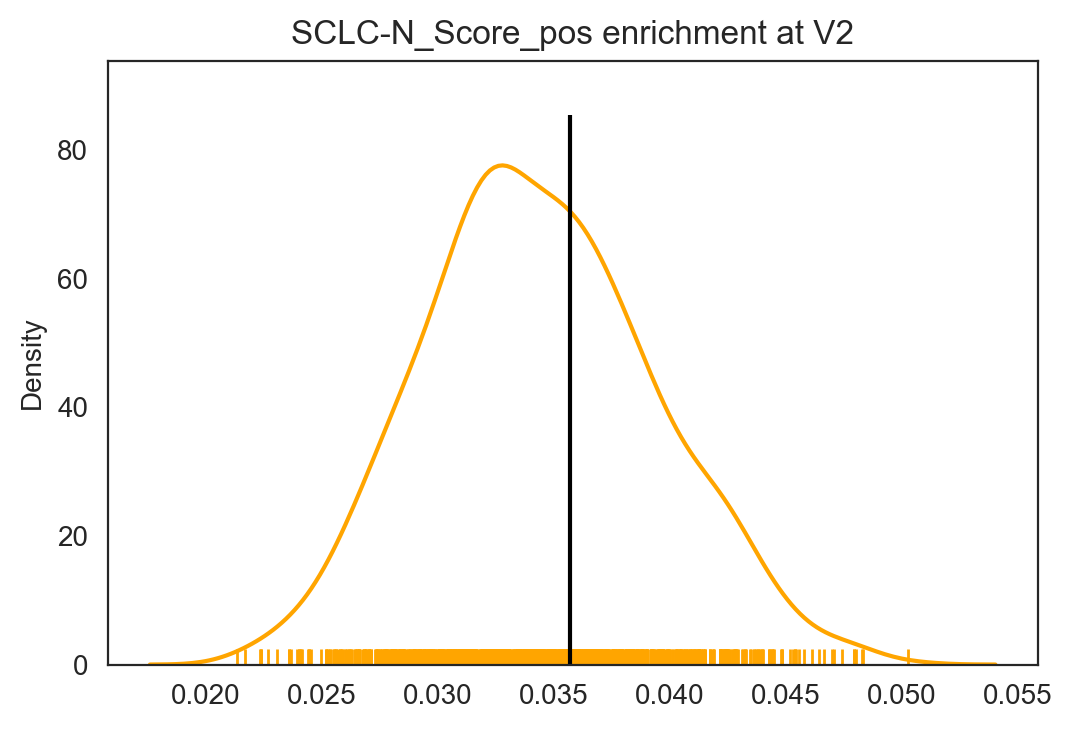

	 p-value for SCLC-N_Score_pos: 0.385


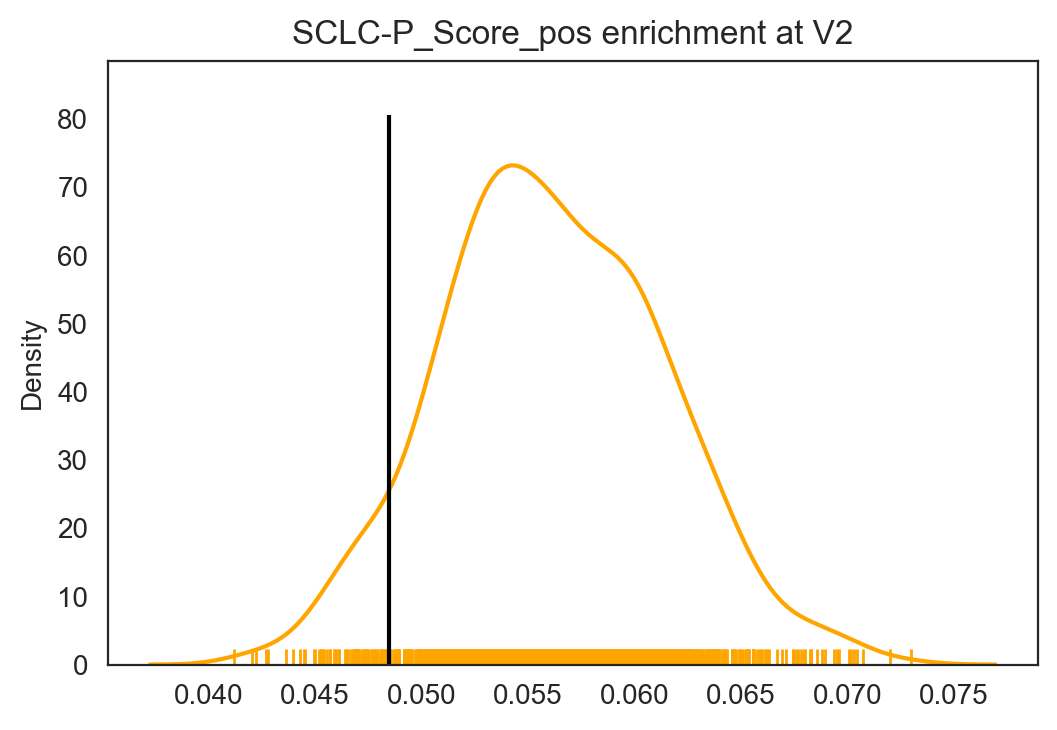

	 p-value for SCLC-P_Score_pos: 0.927


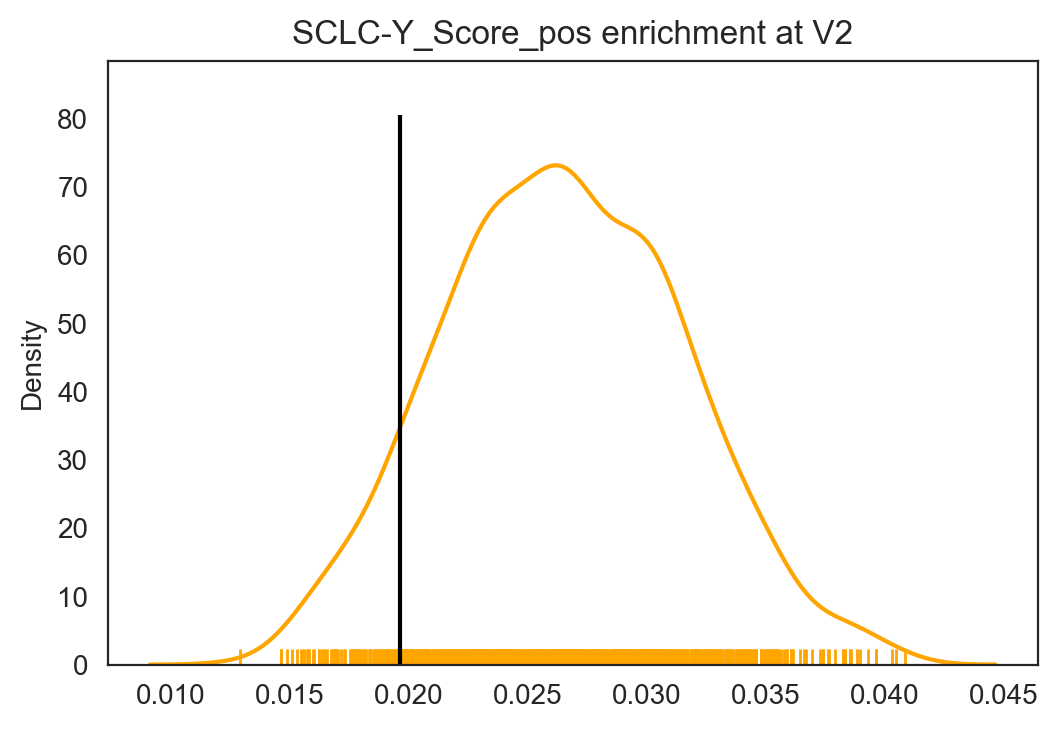

	 p-value for SCLC-Y_Score_pos: 0.914
Archetype: V3


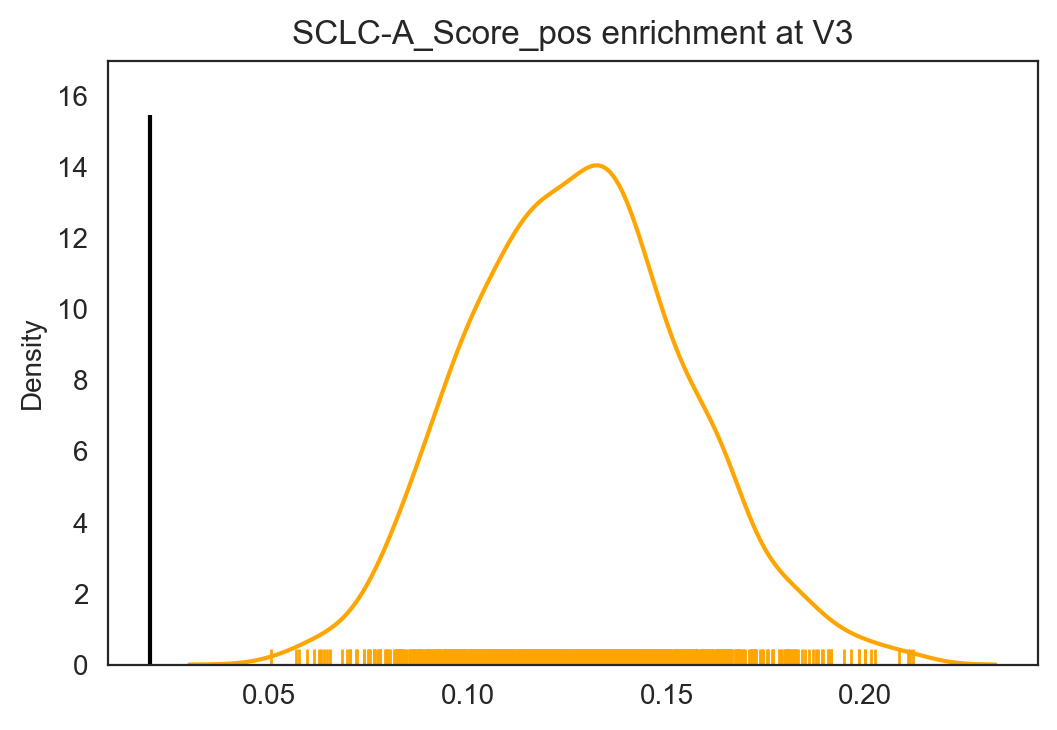

	 p-value for SCLC-A_Score_pos: 1.0


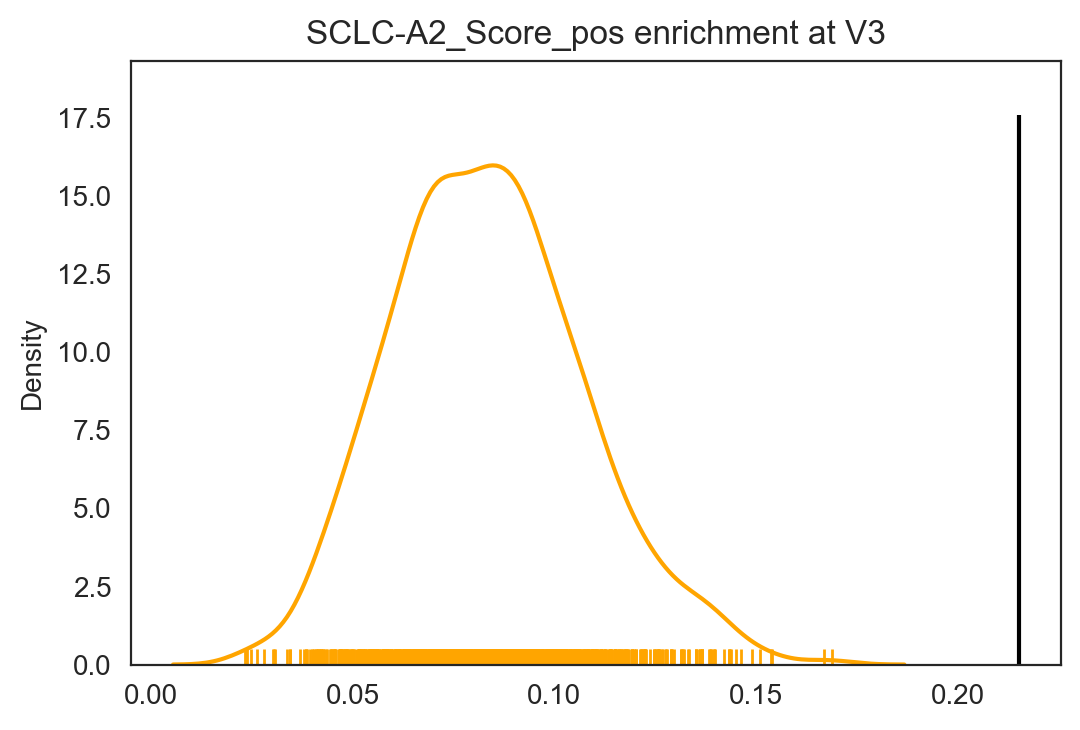

	 p-value for SCLC-A2_Score_pos: 0.0


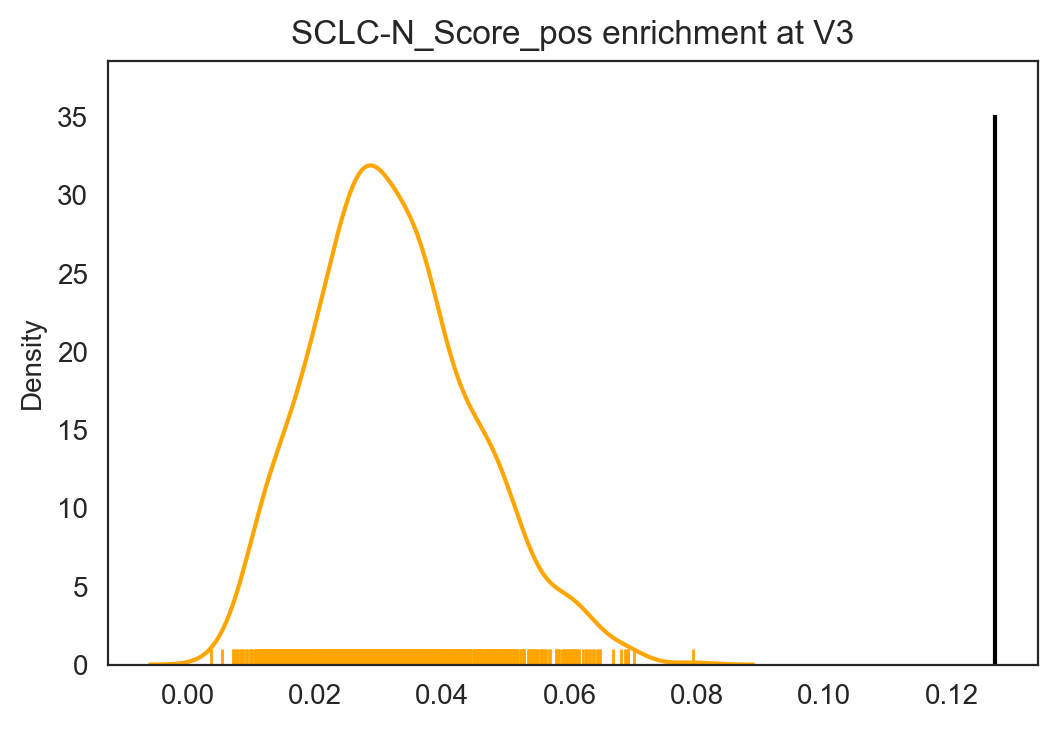

	 p-value for SCLC-N_Score_pos: 0.0


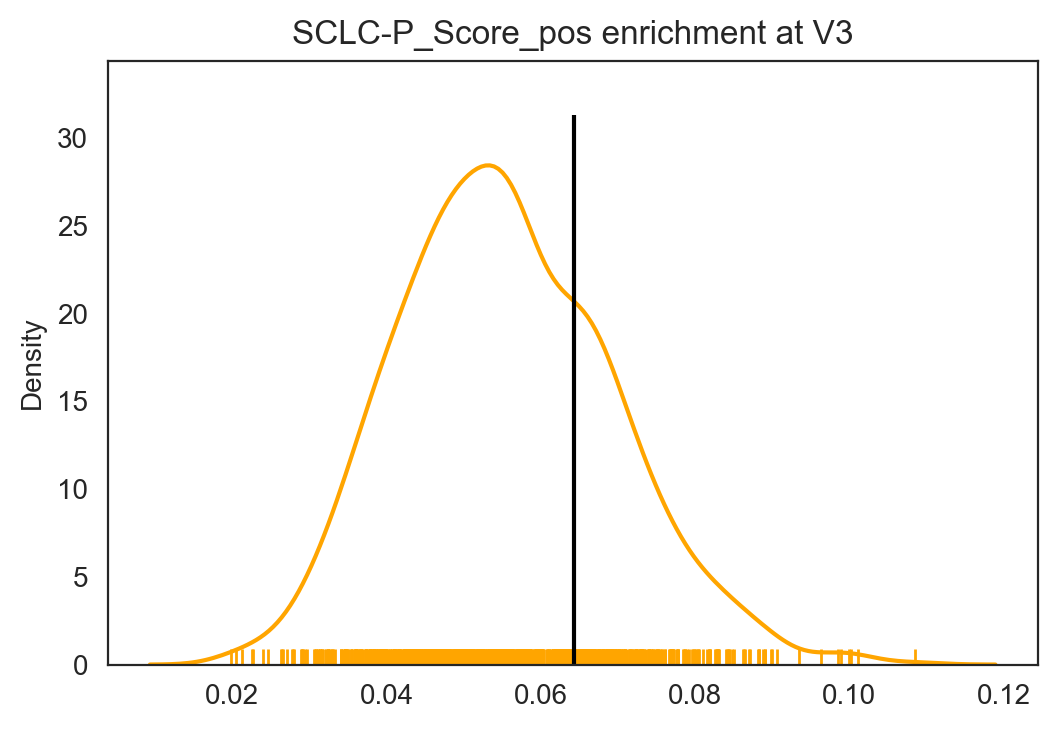

	 p-value for SCLC-P_Score_pos: 0.2609999999999999


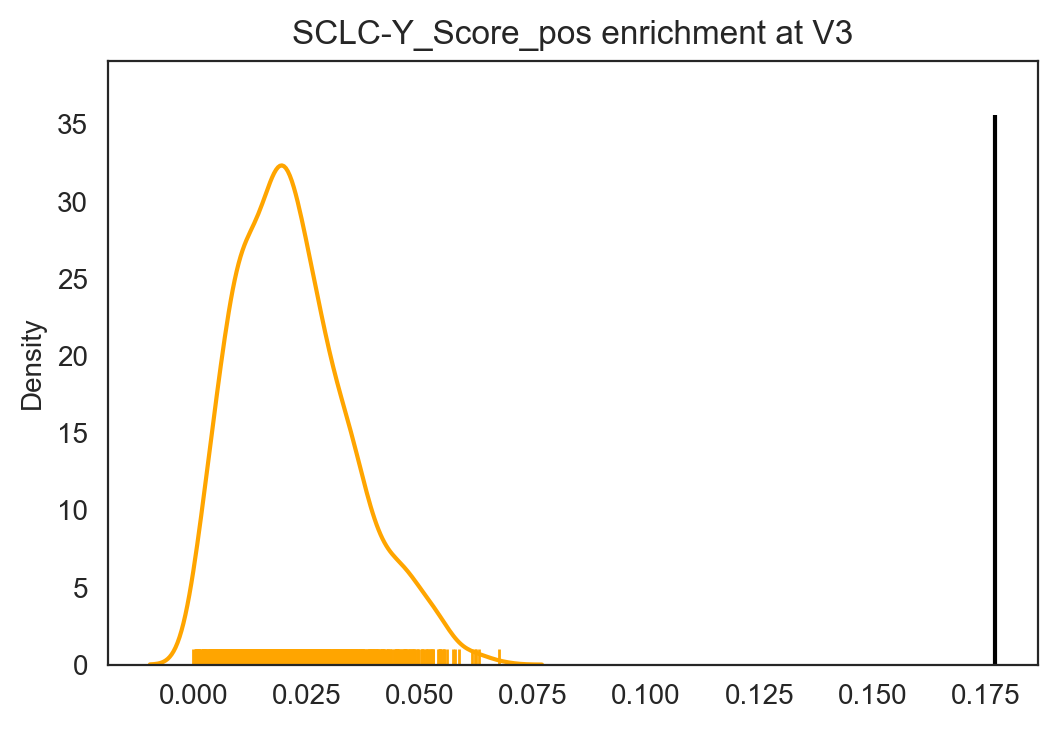

	 p-value for SCLC-Y_Score_pos: 0.0


In [113]:
score = X_magic.obs[[i for i in X_magic.obs if '_Score_pos' in i]]
score = score.fillna(0)
p_values_mean_corr, p_values_mean = mb.ar.permutation_enrichment_test(X_magic, score, plot = True, stat = 'mean', verbose = False, correction='holm', figsize = (6,4), save = 'enrichment_cc.pdf')

In [120]:
p_values_mean_corr

variable SCLC-A2_Score_pos SCLC-A_Score_pos SCLC-N_Score_pos SCLC-P_Score_pos  \
id                                                                              
V1                     0.0              0.0                1                1   
V2                       1                1                1                1   
V3                     0.0                1              0.0                1   

variable SCLC-Y_Score_pos  
id                         
V1                      1  
V2                      1  
V3                    0.0

In [17]:
 X_magic.obs['ParetoTI_specialists'] = [{'V1':'A/A2',
 'V2':'None',
 'V3':'A2/N/Y',
 np.nan: np.nan}[i] for i in X_magic.obs.specialists_ParetoTI_S]
    

In [18]:
X_magic.uns['ParetoTI_specialists_colors'] = ['#F8766D','#E18A00','#BE9C00']



In [114]:
arc_pca = pd.read_csv('../../out/human-tumors/ParetoTI/arc_ave_positions_pca_cc.csv', index_col=0)

In [115]:
arc_pca

V1          V2          V3
PC_1  -13.294176  -86.158649  411.648736
PC_2  -90.317319  106.679466   82.806931
PC_3    4.358265   -5.097239  -10.348617
PC_4   -0.863883    0.139269    7.313630
PC_5    0.006826   -0.114199   -1.437829
PC_6   -0.335699    0.041051    3.943339
PC_7   -0.127221   -0.419773    3.009367
PC_8    0.036412   -0.550788    1.574717
PC_9    0.420536   -0.245968   -4.750735
PC_10   0.142552   -0.326518   -0.735345
PC_11   0.450408   -0.270084   -2.161011

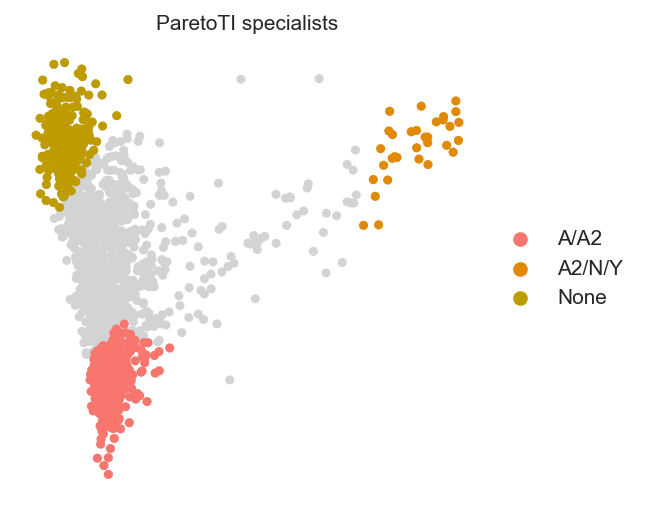

In [29]:
scv.pl.pca(X_magic, color = ['ParetoTI_specialists'], legend_loc = 'on right', dpi = 150, figsize = (4,4), show = False)
# plt.scatter(arc_pca.loc['PC_1'], arc_pca.loc['PC_2'], c = 'k')
plt.savefig('./figures/Pareto_specialists_pca_CC.pdf')


<AxesSubplot:xlabel='ParetoTI_specialists', ylabel='tumor'>

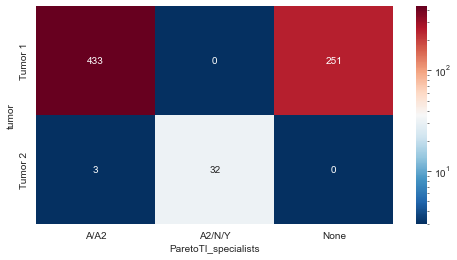

In [121]:
from matplotlib.colors import LogNorm, Normalize

sns.heatmap(pd.crosstab(X_magic.obs.tumor, X_magic.obs.ParetoTI_specialists)[['A/A2','A2/N/Y','None']], annot=True,
            norm=LogNorm(clip = True), fmt = 'd', cmap = 'RdBu_r')
# plt.savefig('./figures/heatmap_ParetoTI-specialists_timepoints.pdf')


In [14]:
mb.pl.subtype_bar(X_magic,groupby='tumor', fname = 'human_tumor', pheno_name="subtype_labeled")#, custom_palette=['#F8766D','orange','grey','#2b8cbe','gold','#2ca25f'])

KeyError: 'subtype_labeled'